# Flight Research and Analytics EDA

## Setup:

### *Load Libraries -*

In [72]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [73]:
import boto3
import sagemaker
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from datetime import datetime as dt
import itertools
import time
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline
%config InlineBackend.figure_format='retina'

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [74]:
%%bash

aws s3 ls s3://${bucket}/

2023-03-04 00:23:32 sagemaker-studio-328876407652-1zzlgzyu0f7
2023-03-04 00:28:42 sagemaker-us-east-1-328876407652
2023-03-18 04:47:03 testfinalproject088


### *Copy Data From the Public S3 Bucket to our Private S3 Bucket -*

In [4]:
# Copying airline flights table
!aws s3 cp s3://sagemaker-us-east-1-993410942383/content-project/airline_data/airline_flights_table/arline_flights_table.csv s3://sagemaker-us-east-1-328876407652/airline_data/arline_flights_table.csv

# Copying cancellation code table
!aws s3 cp s3://sagemaker-us-east-1-993410942383/content-project/airline_data/cancellation_table/CancellationCode_table.csv s3://sagemaker-us-east-1-328876407652/airline_data/CancellationCode_table.csv

# Copying the airport code table
!aws s3 cp s3://sagemaker-us-east-1-993410942383/content-project/airline_data/airport_codes_table/airport_codes_table.csv s3://sagemaker-us-east-1-328876407652/airline_data/airport_codes_table.csv

# Copying JFK weather 2016 table
!aws s3 cp s3://sagemaker-us-east-1-993410942383/content-project/airline_data/JFK_weather/JFK_weather_Jan_2016.csv s3://sagemaker-us-east-1-328876407652/airline_data/JFK_weather_Jan_2016.csv

# Copying weather 2016 table
!aws s3 cp s3://sagemaker-us-east-1-993410942383/content-project/airline_data/WeatherUS_2016/WeatherUS_2016.csv s3://sagemaker-us-east-1-328876407652/airline_data/WeatherUS_2016.csv

copy: s3://sagemaker-us-east-1-993410942383/content-project/airline_data/airline_flights_table/arline_flights_table.csv to s3://sagemaker-us-east-1-328876407652/airline_data/arline_flights_table.csv
copy: s3://sagemaker-us-east-1-993410942383/content-project/airline_data/cancellation_table/CancellationCode_table.csv to s3://sagemaker-us-east-1-328876407652/airline_data/CancellationCode_table.csv
copy: s3://sagemaker-us-east-1-993410942383/content-project/airline_data/airport_codes_table/airport_codes_table.csv to s3://sagemaker-us-east-1-328876407652/airline_data/airport_codes_table.csv
copy: s3://sagemaker-us-east-1-993410942383/content-project/airline_data/JFK_weather/JFK_weather_Jan_2016.csv to s3://sagemaker-us-east-1-328876407652/airline_data/JFK_weather_Jan_2016.csv
copy: s3://sagemaker-us-east-1-993410942383/content-project/airline_data/WeatherUS_2016/WeatherUS_2016.csv to s3://sagemaker-us-east-1-328876407652/airline_data/WeatherUS_2016.csv


In [6]:
# To list the private S3 Bucket content
!aws s3 ls s3://sagemaker-us-east-1-328876407652/airline_data/

                           PRE Flights_JFK/
                           PRE Flights_JFK_mod/
                           PRE JFK_weather_detailed/
                           PRE Weather_JFK/
2023-03-25 20:09:21          0 
2023-03-25 20:53:36         84 CancellationCode_table.csv
2023-03-27 04:07:37     757224 JFK_Flight_Weather_Data_FinalSet.csv
2023-03-27 05:50:01     756646 JFK_Flight_Weather_Prelim.csv
2023-03-25 20:53:38       1362 JFK_weather_Jan_2016.csv
2023-03-25 20:53:38  162079876 WeatherUS_2016.csv
2023-03-25 20:53:37     312298 airport_codes_table.csv
2023-03-25 20:53:34  149933579 arline_flights_table.csv


## Create Athena Database & Establish Connection:

In [6]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0

In [7]:
# Import PyAthena
from pyathena import connect

In [8]:
ingest_create_athena_db_passed = False

In [9]:
%store -r ingest_create_athena_table_parquet_passed

no stored variable or alias ingest_create_athena_table_parquet_passed


In [10]:
# Create Athena Database
database_name = "testanalysis"

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [11]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [12]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

CREATE DATABASE IF NOT EXISTS testanalysis


In [13]:
# Verify The Database Has Been Created Succesfully
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,flight_analysis
2,testanalysis


## Create Tables For Athena Database:

In [75]:
# Connecting to S3 bucket
cancellation_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/cancellation_table'
airlineID_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/airlineID_carrier_table'
flights_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/airline_flights_table'
weather_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/WeatherUS_2016'
airportCodes_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/airport_codes_table'

In [76]:
# Creating Athena tables
table1_name_cancellationcode = "cancellation_code"
table_name_airportCodes = 'airport_codes_table'
table_name_airlineID = 'airlineID_table'
table_name_flights = 'flights_table_21'
table_name_weather = 'weather_table'

In [50]:
# Drop Table if Needed

#drop_table_name = "flights_table_21"
#drop_table_query = f"DROP TABLE IF EXISTS {database_name}.{drop_table_name}"

#df_show = pd.read_sql(drop_table_query, conn)
#df_show.head()

""


### *Cancellation Codes Table -* 

In [15]:
statement1 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         Code string,
         Description string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table1_name_cancellationcode, cancellation_s3
)

In [16]:
pd.read_sql(statement1, conn)

""


In [17]:
# Verify the table was created by way of a query
query1 = "SELECT * FROM {}.{}".format(database_name, table1_name_cancellationcode)
pd.read_sql(query1, conn)

,index,code,description
0,0,A,Carrier
1,1,B,Weather
2,2,C,National Air System
3,3,D,Security


### *Flights Table -* 

In [51]:
statement2 = """CREATE EXTERNAL TABLE {}.{}(
         Index string,
         Year	int,
         Quarter	int,
         Month 	int,
         DayofMonth 	int,
         DayOfWeek 	int,
         FlightDate 	string,
         UniqueCarrier 	string,
         AirlineID	int,
         Carrier	string,
         TailNum	string,
         FlightNum	int,
         OriginAirportID	int,
         OriginAirportSeqID	int,
         OriginCityMarketID	int,
         Origin	string,
         OriginCityName	string,
         OriginState	string,
         OriginStateFips	int,
         OriginStateName	string,
         OriginWac	int,
         DestAirportID	int,
         DestAirportSeqID	int,
         DestCityMarketID	int,
         Dest	string,
         DestCityName	string,
         DestState	string,
         DestStateFips	int,
         DestStateName	string,
         DestWac	int,
         CRSDepTime	int,
         DepTime	string,
         DepDelay	string,
         DepDelayMinutes	string,
         DepDel15	string,
         DepartureDelayGroups	string,
         DepTimeBlk	string,
         TaxiOut	string,
         WheelsOff	string,
         WheelsOn	string,
         TaxiIn	string,
         CRSArrTime	string,
         ArrTime	string,
         ArrDelay	string,
         ArrDelayMinutes	string,
         ArrDel15	string,
         ArrivalDelayGroups	string,
         ArrTimeBlk	string,
         Cancelled	int,
         CancellationCode	string,
         Diverted	int,
         CRSElapsedTime	string,
         ActualElapsedTime	string,
         AirTime	string,
         Flights	string,
         Distance	string,
         DistanceGroup	int,
         CarrierDelay	string,
         WeatherDelay	string,
         NASDelay	string,
         SecurityDelay	string,
         LateAircraftDelay	string,
         FirstDepTime	string,
         TotalAddGTime	string,
         LongestAddGTime	string,
         DivAirportLandings	string,
         DivReachedDest	string,
         DivActualElapsedTime	string,
         DivArrDelay	string,
         DivDistance	string,
         Div1Airport	string,
         Div1AirportID	string,
         Div1AirportSeqID	string,
         Div1WheelsOn	string,
         Div1TotalGTime	string,
         Div1LongestGTime	string,
         Div1WheelsOff	string,
         Div1TailNum	string,
         Div2Airport	string,
         Div2AirportID	string,
         Div2AirportSeqID	string,
         Div2WheelsOn	string,
         Div2TotalGTime	string,
         Div2LongestGTime	string
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_flights, flights_s3
)

In [52]:
pd.read_sql(statement2, conn)

""


In [55]:
query2_1 = "SELECT Index, FlightDate, FlightNum, OriginAirportID, OriginAirportSeqID, OriginCityMarketID, Origin, OriginCityName, OriginState, OriginStateFips, OriginStateName, Dest FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_name_flights)
pd.read_sql(query2_1, conn)

,Index,FlightDate,FlightNum,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,Dest
0,0,2016-01-06,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,DTW
1,1,2016-01-07,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,DTW
2,10,2016-01-16,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,DTW
3,100,2016-01-13,45,12478,1247803,31703,JFK,"New York, NY",NY,36,New York,SEA
4,1000,2016-01-17,80,15376,1537602,30436,TUS,"Tucson, AZ",AZ,4,Arizona,DFW
5,10000,2016-01-14,271,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,MIA
6,100000,2016-01-18,2035,15024,1502403,34945,STT,"Charlotte Amalie, VI",VI,78,U.S. Virgin Islands,SJU
7,100001,2016-01-18,2036,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,BOS
8,100002,2016-01-18,2051,10721,1072102,30721,BOS,"Boston, MA",MA,25,Massachusetts,MCO
9,100003,2016-01-18,2054,14843,1484304,34819,SJU,"San Juan, PR",PR,72,Puerto Rico,FLL


In [56]:
# Verify the table was created by way of a query
query2_2 = "SELECT * FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_name_flights)
pd.read_sql(query2_2, conn)

,index,year,quarter,month,dayofmonth,dayofweek,flightdate,uniquecarrier,airlineid,carrier,...,div1totalgtime,div1longestgtime,div1wheelsoff,div1tailnum,div2airport,div2airportid,div2airportseqid,div2wheelson,div2totalgtime,div2longestgtime
0,0,2016,1,1,6,3,2016-01-06,AA,19805,AA,...,,,,,,,,,,
1,1,2016,1,1,7,4,2016-01-07,AA,19805,AA,...,,,,,,,,,,
2,10,2016,1,1,16,6,2016-01-16,AA,19805,AA,...,,,,,,,,,,
3,100,2016,1,1,13,3,2016-01-13,AA,19805,AA,...,,,,,,,,,,
4,1000,2016,1,1,17,7,2016-01-17,AA,19805,AA,...,,,,,,,,,,
5,10000,2016,1,1,14,4,2016-01-14,AA,19805,AA,...,,,,,,,,,,
6,100000,2016,1,1,18,1,2016-01-18,B6,20409,B6,...,,,,,,,,,,
7,100001,2016,1,1,18,1,2016-01-18,B6,20409,B6,...,,,,,,,,,,
8,100002,2016,1,1,18,1,2016-01-18,B6,20409,B6,...,,,,,,,,,,
9,100003,2016,1,1,18,1,2016-01-18,B6,20409,B6,...,,,,,,,,,,


### *Airline Carrier ID Table -*

In [25]:
statement3 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         Code string,
         Description string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_airlineID, airlineID_s3
)

In [26]:
pd.read_sql(statement3, conn)

""


In [27]:
query3 = "SELECT * FROM {}.{}".format(database_name, table_name_airlineID)
pd.read_sql(query3, conn)

,index,code,description
0,0,19031,Mackey International Inc.: MAC
1,1,19032,Munz Northern Airlines Inc.: XY
2,2,19033,Cochise Airlines Inc.: COC
3,3,19034,Golden Gate Airlines Inc.: GSA
4,4,19035,Aeromech Inc.: RZZ
...,...,...,...
1605,1605,21694,Silk Way West Airlines: 7L
1606,1606,21697,Orenburg Airlines: R2
1607,1607,21702,WestJet Encore Ltd.: WR
1608,1608,21707,Hong Kong Airlines Limited: HX


### *Airport Codes Table -*

In [39]:
statement4 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         Code string,
         Description string
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_airportCodes, airportCodes_s3
)

In [40]:
pd.read_sql(statement4, conn)

""


In [42]:
query4 = "SELECT * FROM {}.{}".format(database_name, table_name_airportCodes)
pd.read_sql(query4, conn)

,index,code,description
0,0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,2,04A,"Lik, AK: Lik Mining Camp"
3,3,05A,"Little Squaw, AK: Little Squaw Airport"
4,4,06A,"Kizhuyak, AK: Kizhuyak Bay"
...,...,...,...
6380,6380,ZXZ,"Waterville, WA: Waterville Airport"
6381,6381,ZYL,"Sylhet, Bangladesh: Savannakhet"
6382,6382,ZZU,"Mzuzu, Malawi: Mzuzu Airport"
6383,6383,ZZV,"Zanesville, OH: Zanesville Municipal"


### *Weather Table -*

In [44]:
statement5 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         EventId string,
         Type string,
         Severity string,
         StartTime string,
         EndTime string,
         Precipitation string,
         TimeZone string,
         AirportCode string,
         LocationLat string,
         LocationLng string,
         City string,
         County string,
         State string,
         ZipCode string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_weather, weather_s3
)

In [45]:
pd.read_sql(statement5, conn)

""


In [46]:
query5 = "SELECT * FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_name_weather)
pd.read_sql(query5, conn)

,index,eventid,type,severity,starttime,endtime,precipitation,timezone,airportcode,locationlat,locationlng,city,county,state,zipcode
0,0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.0,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.0,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,10,W-11,Cold,Severe,2016-01-09 16:54:00,2016-01-09 20:34:00,0.0,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,100,W-101,Snow,Light,2016-04-16 09:35:00,2016-04-16 10:15:00,0.03,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,1003621,W-1017246,Snow,Light,2016-01-04 12:15:00,2016-01-04 12:35:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
5,1003622,W-1017247,Snow,Light,2016-01-04 12:55:00,2016-01-04 13:55:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
6,1003623,W-1017248,Snow,Light,2016-01-04 14:15:00,2016-01-04 15:35:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
7,1003624,W-1017249,Snow,Light,2016-01-04 15:55:00,2016-01-04 16:15:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
8,1003625,W-1017250,Rain,Light,2016-01-08 13:55:00,2016-01-08 17:55:00,0.06,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
9,1003626,W-1017251,Rain,Light,2016-01-08 18:15:00,2016-01-08 19:35:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0


## Creating Dataframes: 

In [77]:
# Saving the S3 flight dataset to dataframe
flights_df= pd.read_csv("s3://sagemaker-us-east-1-328876407652/airline_data/arline_flights_table.csv")
flights_df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,0,2016,1,1,6,3,2016-01-06,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,1,1,7,4,2016-01-07,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2016,1,1,8,5,2016-01-08,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2016,1,1,9,6,2016-01-09,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2016,1,1,10,7,2016-01-10,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
# Saving the S3 cancellation code dataset to dataframe
CancellationCode_df= pd.read_csv("s3://sagemaker-us-east-1-328876407652/airline_data/CancellationCode_table.csv")
CancellationCode_df.head()

,Unnamed: 0,Code,Description
0,0,A,Carrier
1,1,B,Weather
2,2,C,National Air System
3,3,D,Security


In [79]:
# Saving the S3 airport code dataset to dataframe
AirportCodes_df= pd.read_csv("s3://sagemaker-us-east-1-328876407652/airline_data/airport_codes_table.csv")
AirportCodes_df.head()

,Unnamed: 0,Code,Description
0,0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,2,04A,"Lik, AK: Lik Mining Camp"
3,3,05A,"Little Squaw, AK: Little Squaw Airport"
4,4,06A,"Kizhuyak, AK: Kizhuyak Bay"


In [80]:
# Saving the S3 JFK weather dataset to dataframe
JFK_weather_data= pd.read_csv("s3://sagemaker-us-east-1-328876407652/airline_data/JFK_weather_Jan_2016.csv")
JFK_weather_data.head()

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,1/1/2016,44.0,36.0,40,5.4,25,0,0,0,0
1,1/2/2016,41.0,34.0,37.5,3.1,27,0,0,0,0
2,1/3/2016,48.0,35.0,41.5,7.3,23,0,0,0,0
3,1/4/2016,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,1/5/2016,29.0,12.0,20.5,-13.4,44,0,0,0,0


In [81]:
# Saving the S3 weather dataset to dataframe
weather_df= pd.read_csv("s3://sagemaker-us-east-1-328876407652/airline_data/WeatherUS_2016.csv")
weather_df.head()

,Unnamed: 0,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


## Exploratory Data Analysis:

### Section 1 - Understanding the data for quick insights: 

**We need to understand our data in order to prepare for the next steps of feature selection and feature engineering. We will run queries across the data to get some insights on the data and to track down answers to the following questions over the datasets:**

#### *1. Which airline carrier had the most cancelled flights in 2016?* 

In [62]:
# Grouping airline carrier with number of cancelled flights
df_carrier = flights_df.groupby(["UniqueCarrier"]).Cancelled.sum().reset_index()
df_carrier = df_carrier.sort_values('Cancelled')
df_carrier

,UniqueCarrier,Cancelled
6,HA,4
5,F9,77
1,AS,139
10,VX,159
7,NK,308
2,B6,897
3,DL,974
8,OO,984
9,UA,1336
4,EV,1427


Text(0.5, 1.0, 'Cancellations per Carriers')

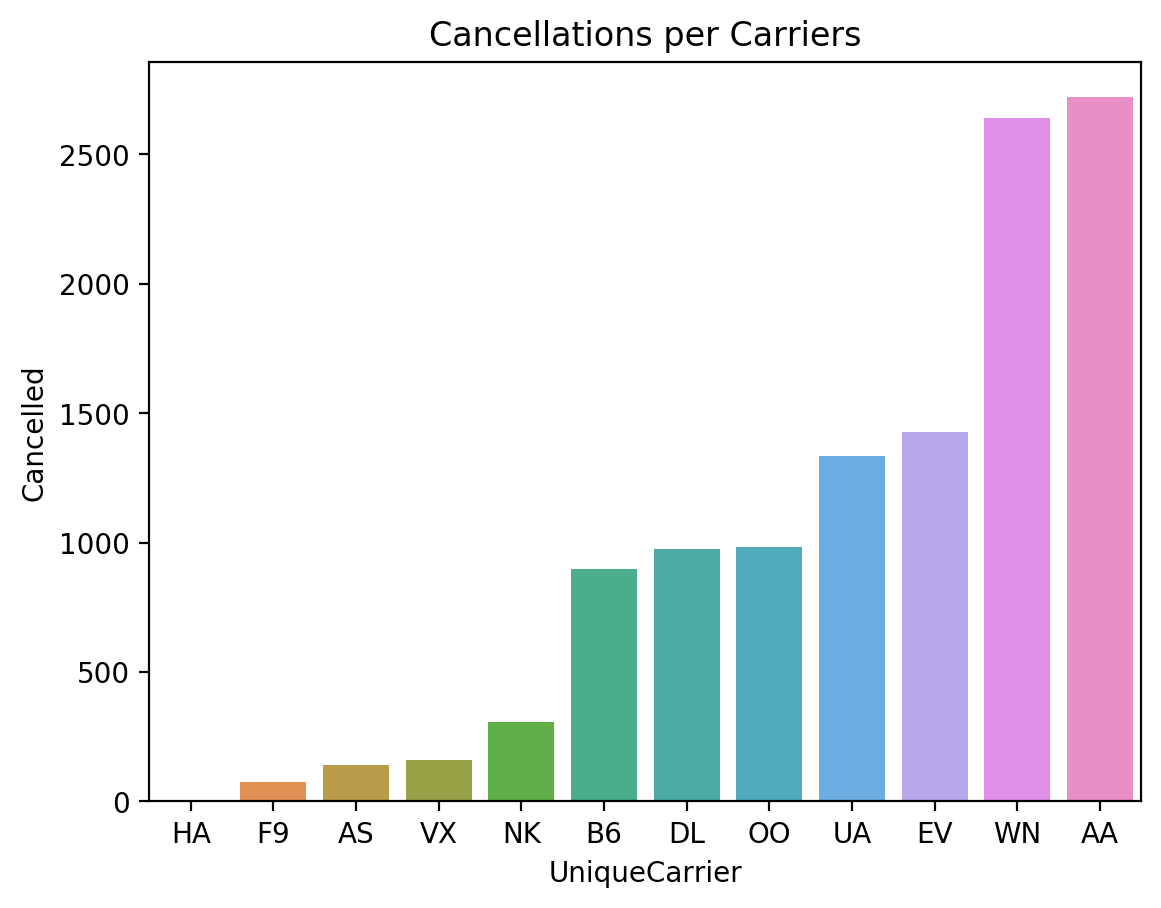

In [63]:
# Plotting the cancellations per carrier on a bar plot
g_bar=sns.barplot(x="UniqueCarrier", y="Cancelled", data=df_carrier)
g_bar.set_title("Cancellations per Carriers")

**We can see that American Airlines has the most cancelled flights. Southwest Airlines is the second highest on the number of cancelled flights. These two airlines also have way more cancelled flights comparing to other airline carriers.** 

#### *2. Which airports had the cancelled flights in 2016?* 

In [101]:
#for index, row in flights_df.iterrows():

# Sum of canceled daily flights:
dff_Origin_airportcode = flights_df.groupby(["Origin"]).Cancelled.sum().sort_values(ascending=False).reset_index()

#dff.head()
dff_Dest_airportcode = flights_df.groupby(["Origin"]).Cancelled.sum().sort_values(ascending=False).reset_index()

In [102]:
dff_Origin_airportcode.head()

,Origin,Cancelled
0,EWR,824
1,BWI,631
2,DCA,609
3,CLT,589
4,LGA,542


Text(0.5, 1.0, 'Cancellations per domestic US airports for January 2016')

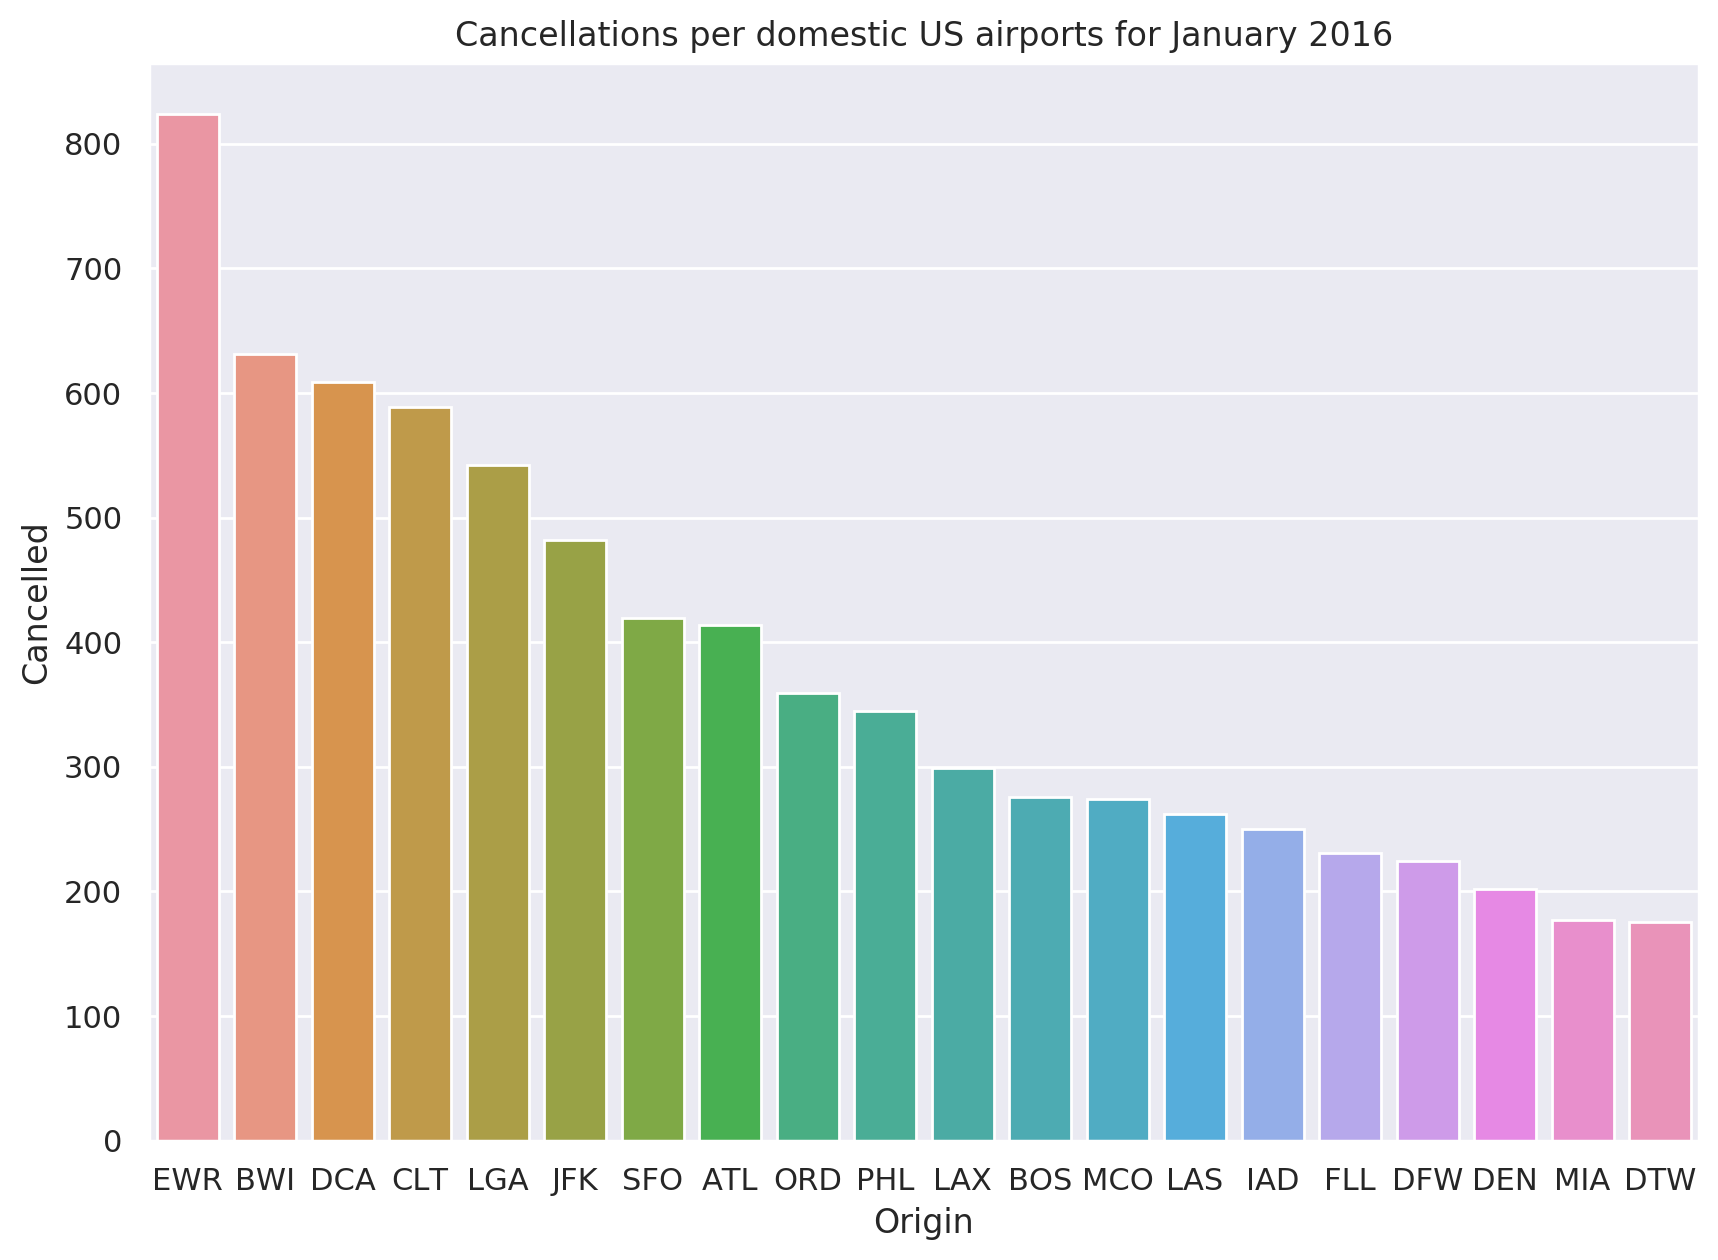

In [103]:
# Plotting the cancellations per domestic US airports for January 2016
g_bar=sns.barplot(x="Origin", y="Cancelled", data=dff_airportOrigin.iloc[0:20])
g_bar.set_title("Cancellations per domestic US airports for January 2016")

**We see that the Newark Liberty International Airport (EWR) has the highest number of flight cancellations in 2016. The other airports that has the highest flight cancellations include Baltimore/Washington International Thurgood Marshall Airport(BWI), Ronald Reagan Washington National Airport (DCA), Charlotte Douglas International Airport (CLT), Tolemaida AB Airport (LGA), and John F. Kennedy International Airport (JFK).**

#### *3. How do the various airlines compare when it came to reasons for cancelled flights?* 

[Text(0, 0, 'Carrier'),
 Text(0, 0, 'Weather'),
 Text(0, 0, 'National Air System')]

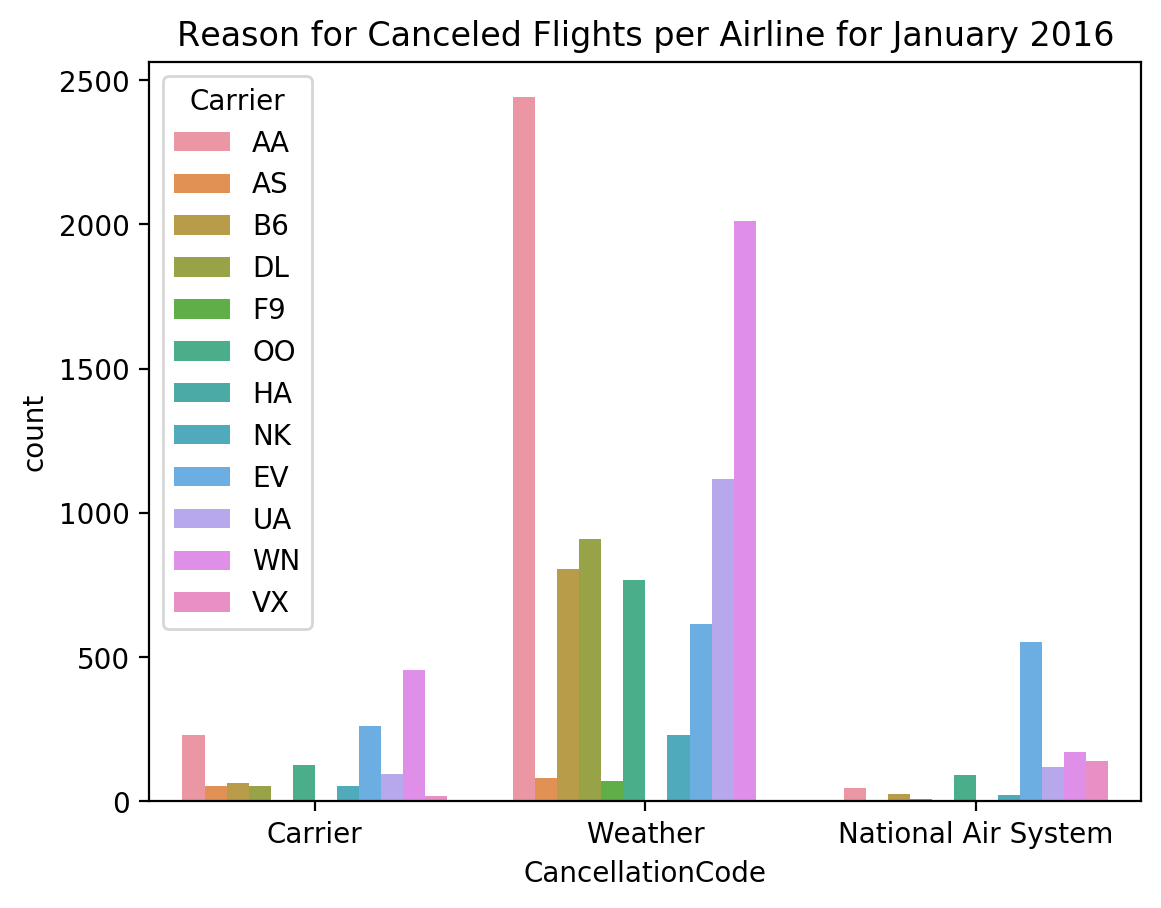

In [69]:
# Plotting the reasons for cancelled flights per airline for January 2016
g=sns.countplot(data=flights_df,
              x='CancellationCode',
              hue='Carrier'
             )
g.set_title('Reason for Canceled Flights per Airline for January 2016')
g.set_xticklabels(['Carrier','Weather','National Air System'])

**We see that weather is the most common reason for flight cancellationas. Interestingly, we can also notice Hawaiian Airlines and Frontier Airlines have the least cancellations for the month of January 2016 as they don't even show up for these cancellation reasons.**

#### *4. How many flights per day were scheduled versus cancelled?*

In [70]:
#for index, row in flights_df.iterrows():
# Sum of canceled daily flights:
dff = flights_df.groupby(["FlightDate"]).Cancelled.sum().reset_index()
#dff.head()

# Sum of total number of flights (since Quarter is always 1):
dff2 = flights_df.groupby(["FlightDate"]).Quarter.count().reset_index()
dff2.rename(columns={'Quarter':'Total_no_Flights'}, inplace=True)
#dff2.head()

dff_flights=pd.merge(dff, dff2, on = "FlightDate")
dff_flights.head()
#flights_sum=flights_df['FlightDate'].groupby(flights_df['Cancelled'] == 1)

,FlightDate,Cancelled,Total_no_Flights
0,2016-01-01,57,13019
1,2016-01-02,52,14869
2,2016-01-03,97,15878
3,2016-01-04,87,15570
4,2016-01-05,204,14582


[Text(0, 0, '01/01'),
 Text(0, 0, '01/02'),
 Text(0, 0, '01/03'),
 Text(0, 0, '01/04'),
 Text(0, 0, '01/05'),
 Text(0, 0, '01/06'),
 Text(0, 0, '01/07'),
 Text(0, 0, '01/08'),
 Text(0, 0, '01/09'),
 Text(0, 0, '01/10'),
 Text(0, 0, '01/11'),
 Text(0, 0, '01/12'),
 Text(0, 0, '01/13'),
 Text(0, 0, '01/14'),
 Text(0, 0, '01/15'),
 Text(0, 0, '01/16'),
 Text(0, 0, '01/17'),
 Text(0, 0, '01/18'),
 Text(0, 0, '01/19'),
 Text(0, 0, '01/20'),
 Text(0, 0, '01/21'),
 Text(0, 0, '01/22'),
 Text(0, 0, '01/23'),
 Text(0, 0, '01/24'),
 Text(0, 0, '01/25'),
 Text(0, 0, '01/26'),
 Text(0, 0, '01/27'),
 Text(0, 0, '01/28'),
 Text(0, 0, '01/29'),
 Text(0, 0, '01/30'),
 Text(0, 0, '01/31')]

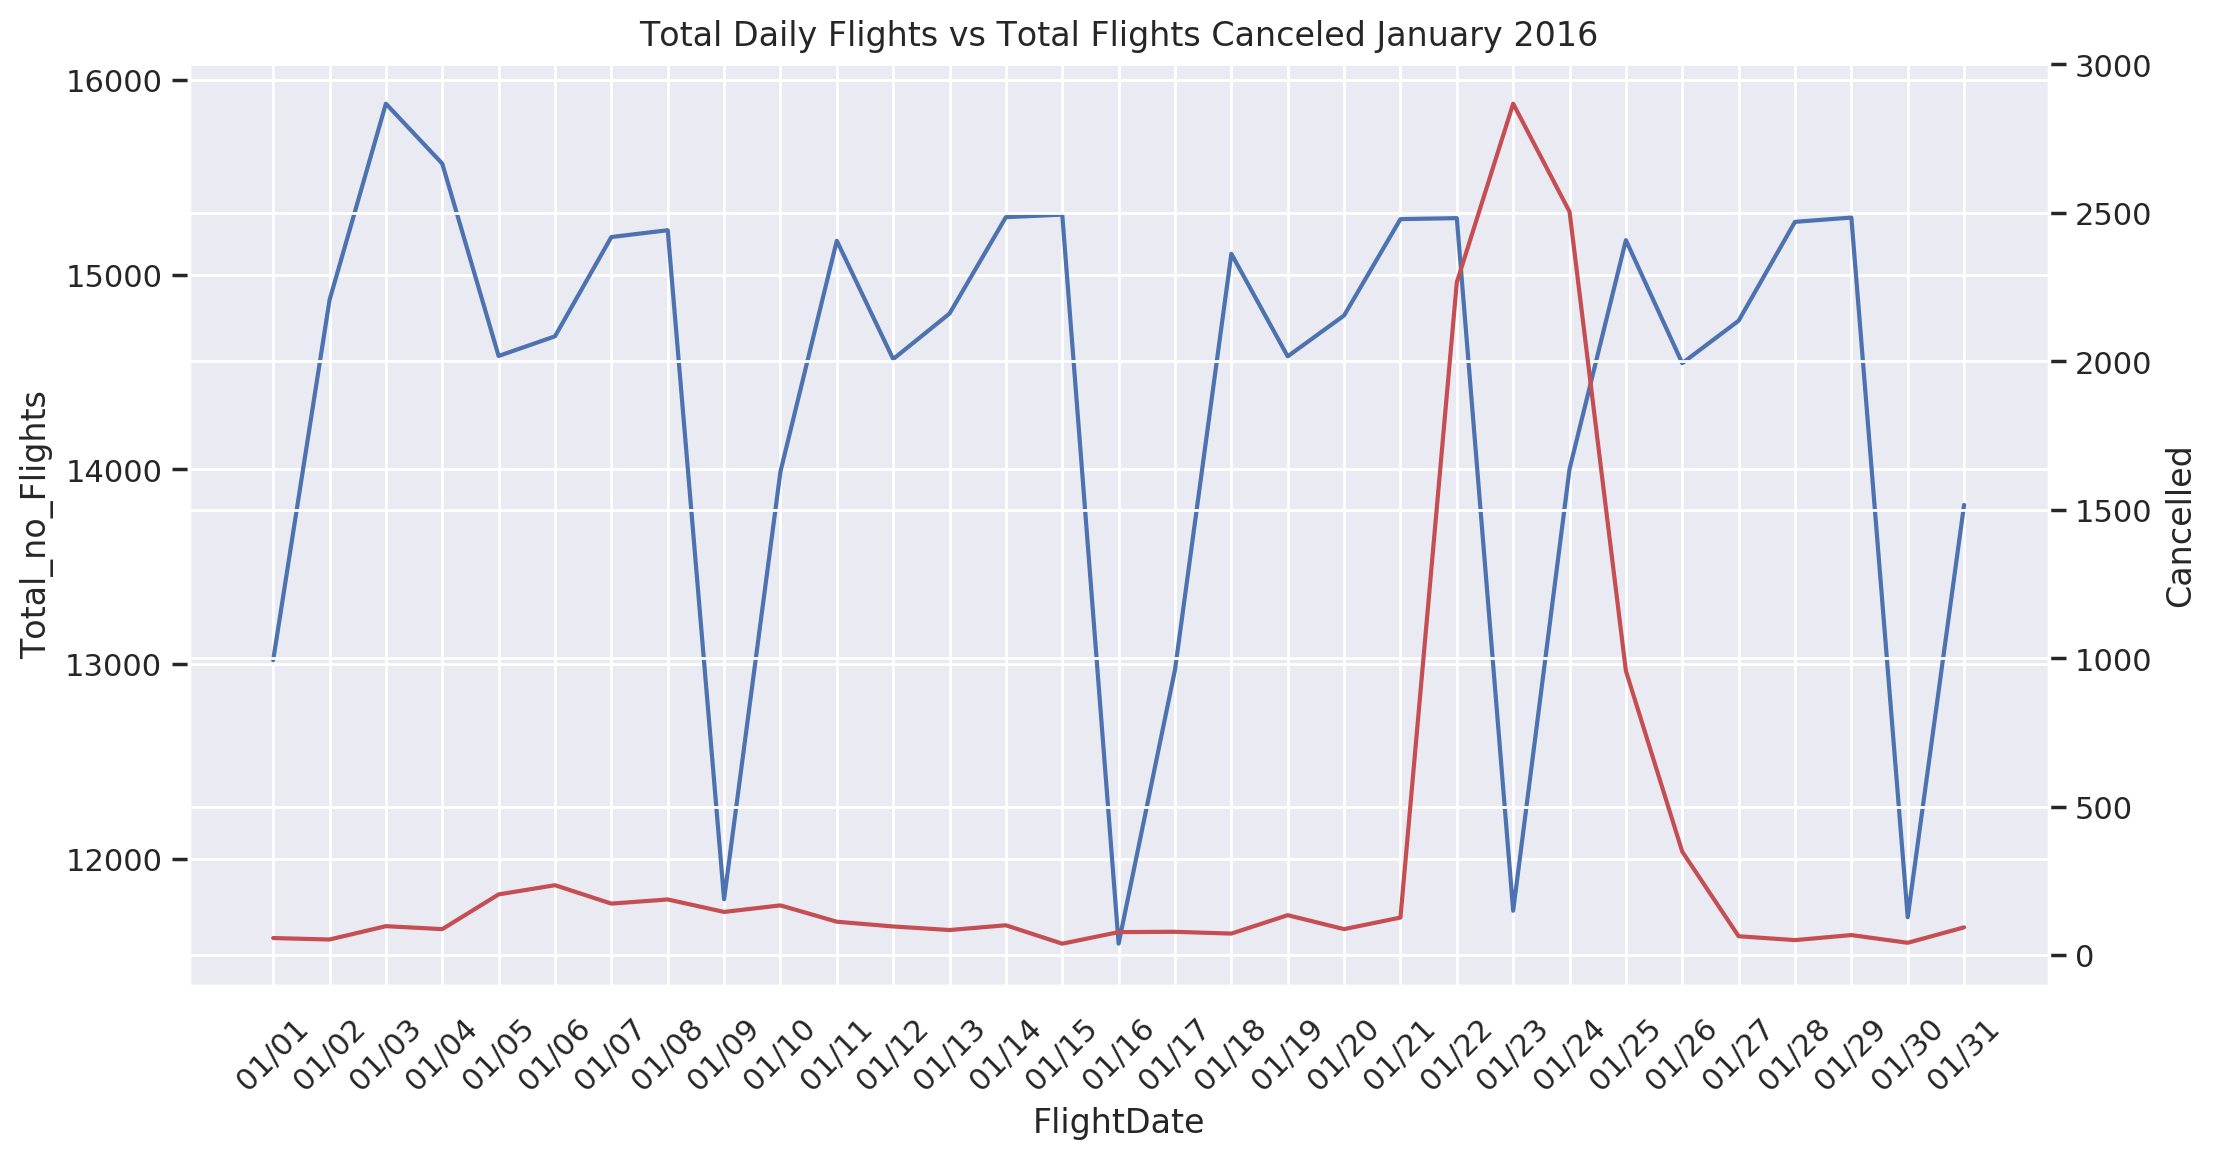

In [73]:
sns.set(rc={'figure.figsize':(10,7)})

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title("Total Daily Flights vs Total Flights Canceled January 2016")
ax2 = ax1.twinx()
#ax3 = ax1.twinx()

#ax2.set(ylim=(0, y2_limit))
g1 = sns.lineplot(data = dff_flights, x = "FlightDate", y = "Total_no_Flights", ax = ax1, color = 'b') # plots the first set
g2 = sns.lineplot(data = dff_flights, x = "FlightDate", y = "Cancelled", ax = ax2, color = 'r') # plots the second set 
#g3 = sns.lineplot(data = df, x = x1, y = y3, ax = ax3, color = y3_color)

#g_line = sns.lineplot(x="FlightDate", y="Total_no_Flights", data=dff_flights)
#g_line.add_lineplot(x="FlightDate",y="Cancelled",data=dff_flights)
g1.set_xticklabels(labels=["01/01","01/02","01/03","01/04","01/05",
                          "01/06","01/07","01/08","01/09","01/10","01/11",
                          "01/12","01/13","01/14","01/15","01/16","01/17",
                          "01/18","01/19","01/20","01/21","01/22","01/23",
                          "01/24","01/25","01/26","01/27","01/28","01/29",
                          "01/30","01/31"], rotation=45)
#g1.set_title("Total Daily Flights vs Total Flights Canceled January 2016")
##g.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])

**It might be interesting to find out what happened between 01/20 and 01/27 of 2016 that caused the larger increase in canceled flights within the domestic US. Keep in mind the double axis to keep both plots on top of one another, but the number of canceled flights is significantly smaller than the number of total flights scheduled for each day.**

#### *5. Which day of the week and month has the most cancellations?*

In [94]:
# Looking at flight cancellations per day of month
df_dayofmonth = flights_df.groupby(["DayofMonth"]).Cancelled.sum().sort_values(ascending=False).reset_index()
df_dayofmonth.head(10)

,DayofMonth,Cancelled
0,23,2868
1,24,2504
2,22,2266
3,25,957
4,26,348
5,6,235
6,5,204
7,8,187
8,7,173
9,10,167


Text(0.5, 1.0, 'Cancellations per Day of Month')

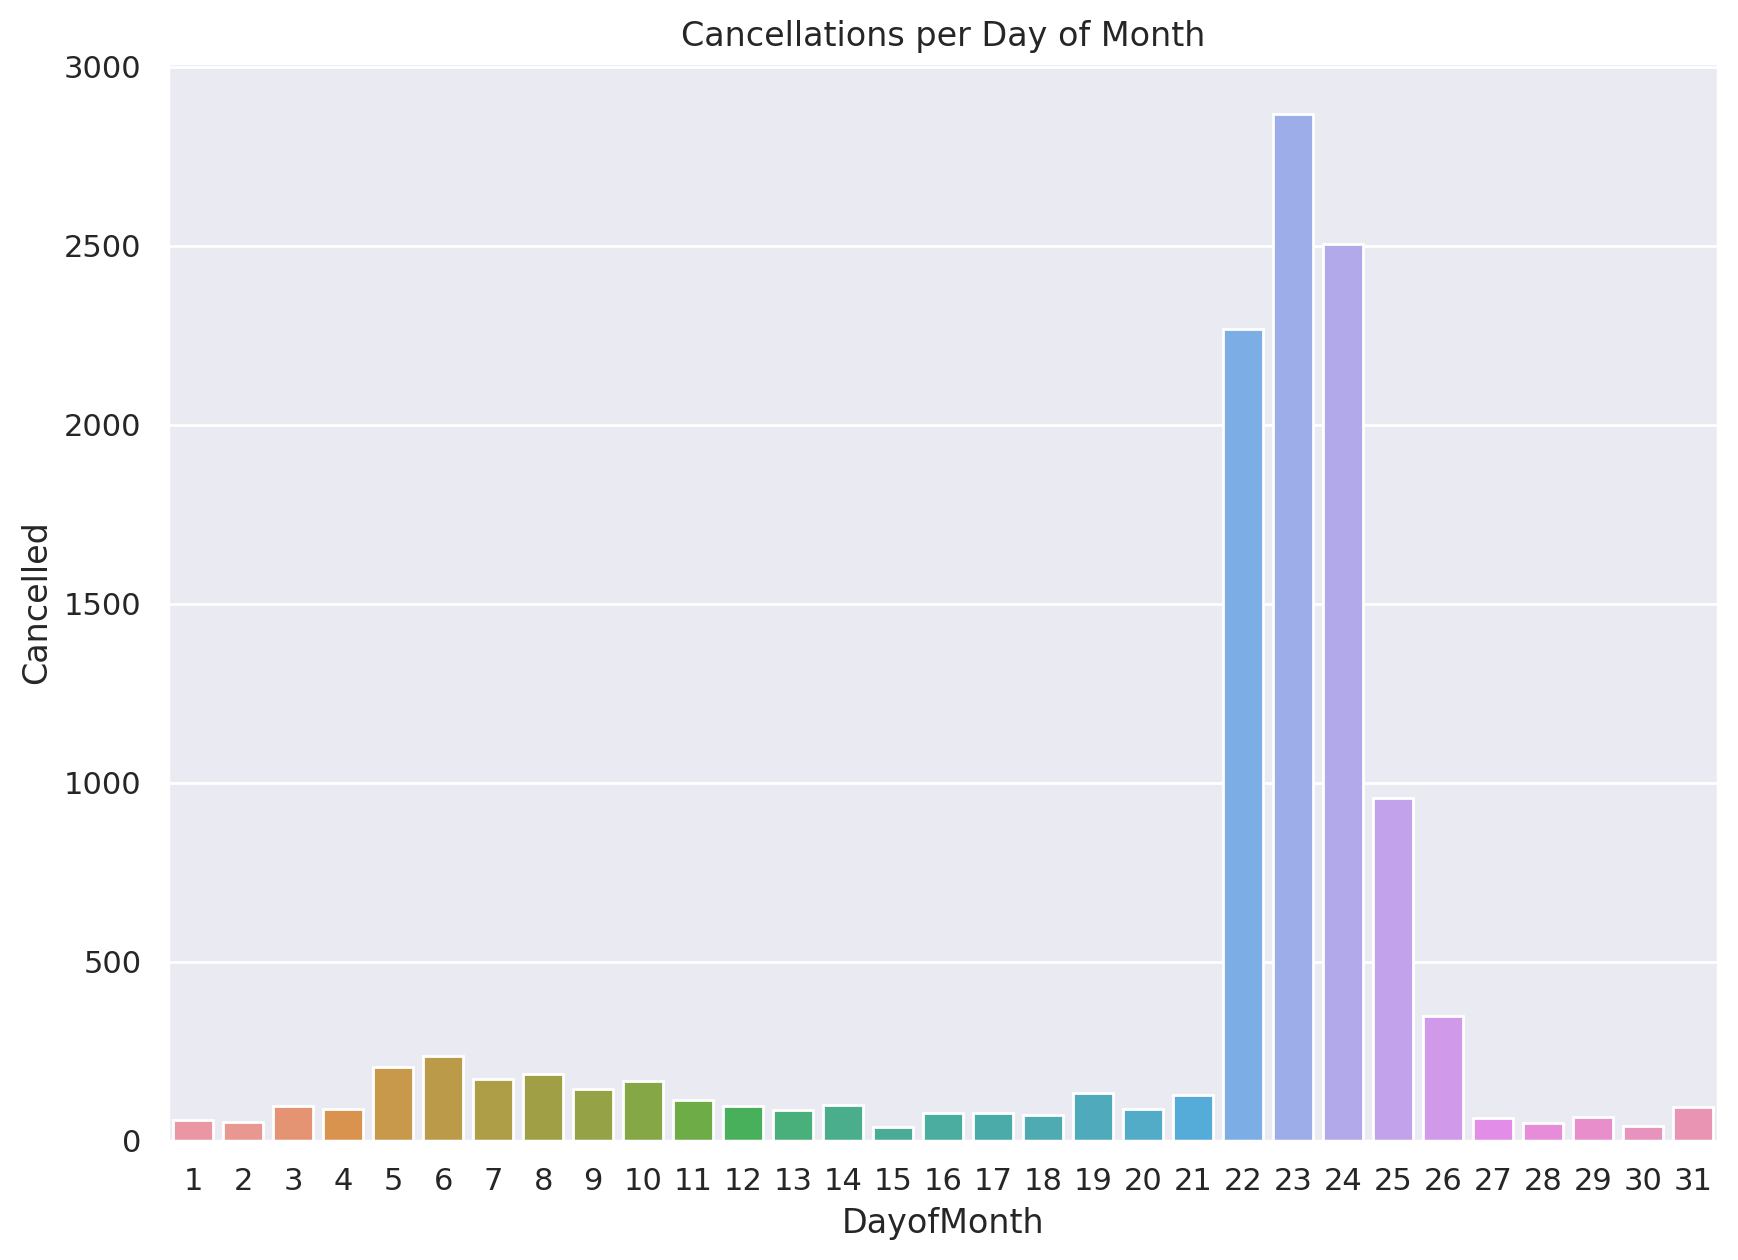

In [97]:
# Plot flight cancellations per day of month
g_bar=sns.barplot(x="DayofMonth", y="Cancelled", data=df_dayofmonth)
g_bar.set_title("Cancellations per Day of Month")

In [96]:
# Looking at flight cancellations per day of week
df_DayOfWeek = flights_df.groupby(["DayOfWeek"]).Cancelled.sum().sort_values(ascending=False).reset_index()
df_DayOfWeek.head(10)

,DayOfWeek,Cancelled
0,6,3183
1,7,2939
2,5,2615
3,1,1228
4,2,782
5,3,469
6,4,449


Text(0.5, 1.0, 'Cancellations per Day Of Week')

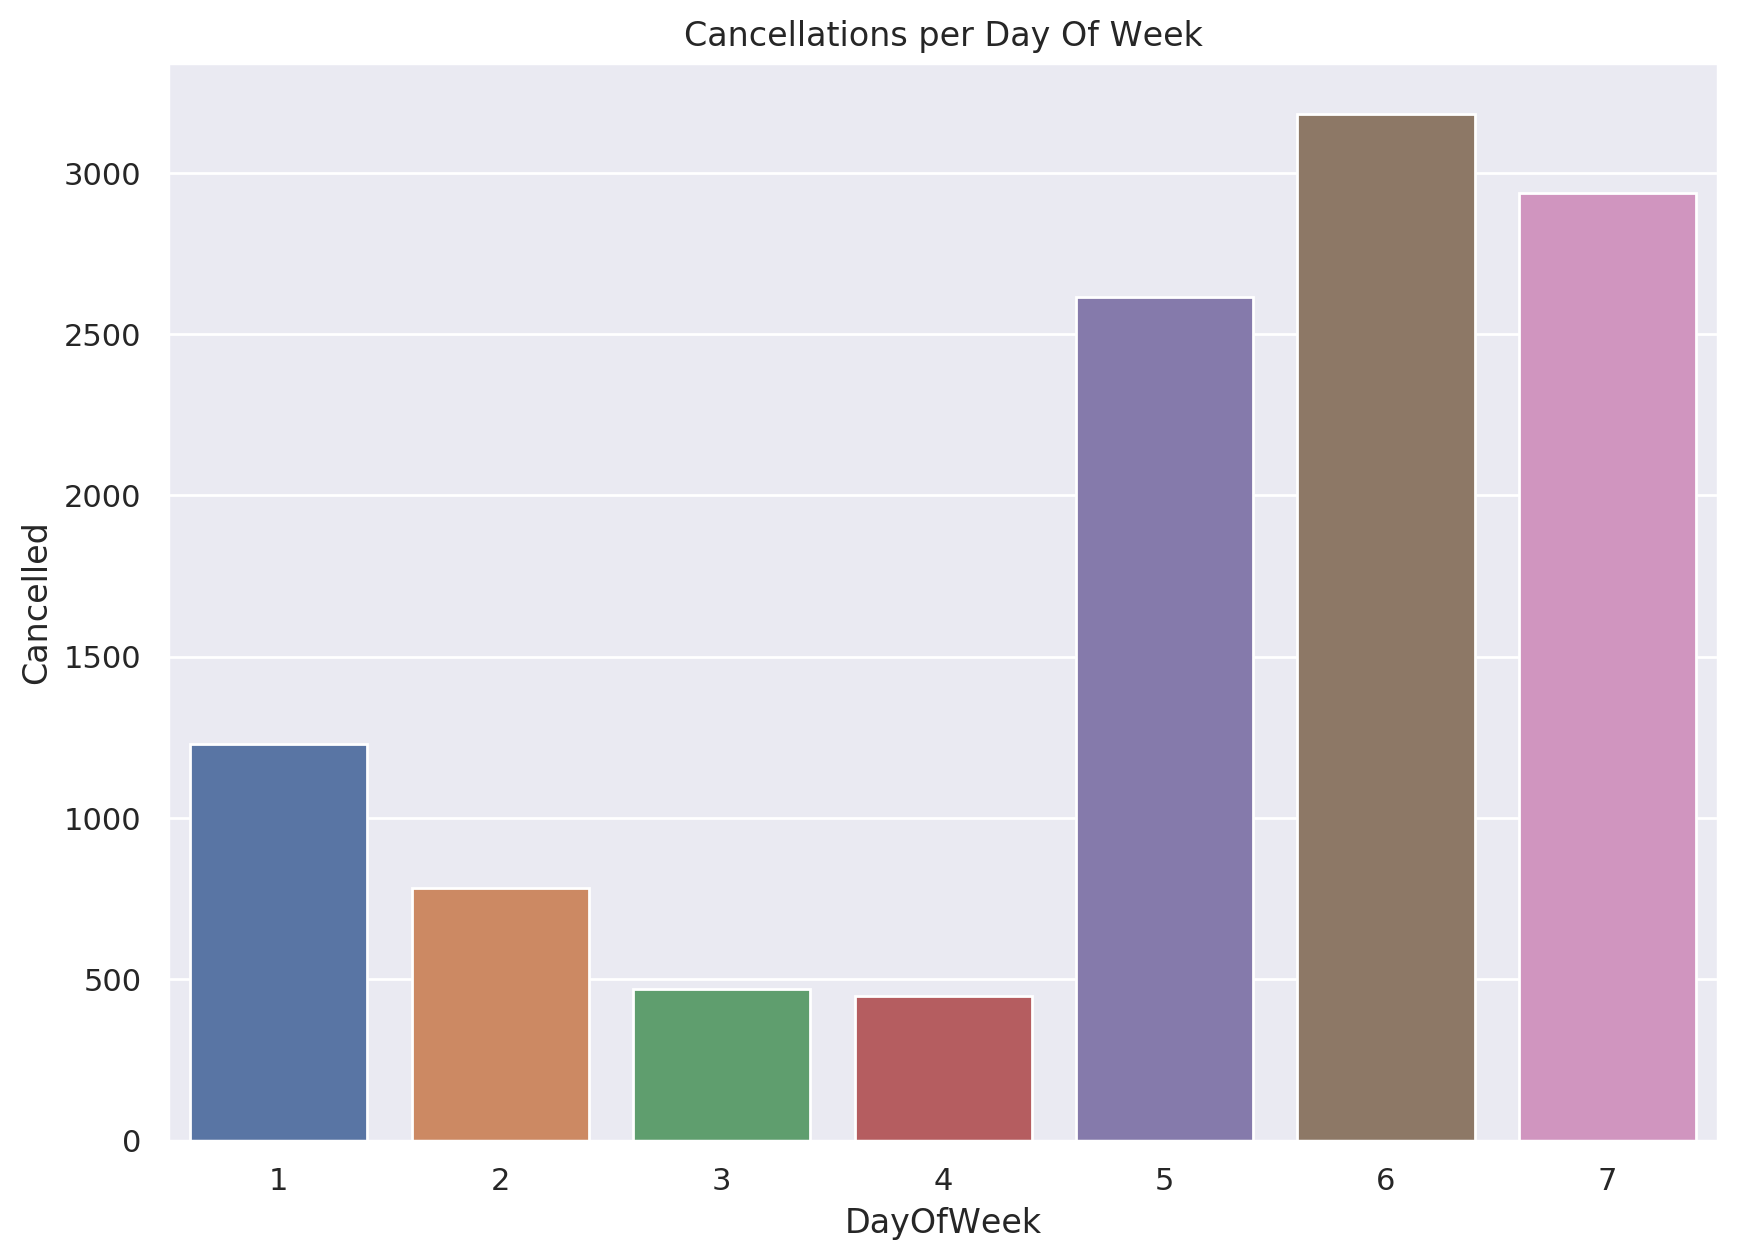

In [98]:
# Plot flight cancellations per day of week
g_bar=sns.barplot(x="DayOfWeek", y="Cancelled", data=df_DayOfWeek)
g_bar.set_title("Cancellations per Day Of Week")

**We see that flights cancellations are more likely to be cancelled during the end of the month and also in the weekends.** 

#### *6. What is the proportion of cancelled flights to total number of flights per airport?*

In [121]:
# Sum of cancelled flights from each airport in 2016
dff_Origin_airportcode = flights_df.groupby(["Origin"]).Cancelled.sum().reset_index()
dff_Origin_airportcode.head()

,Origin,Cancelled
0,ABE,8
1,ABQ,12
2,ABR,0
3,ABY,0
4,ACT,0


In [136]:
# Sum of total number of flights from each airport in 2016
df_total_flights_per_airport = flights_df.groupby(['Origin'])['Origin'].count().reset_index(name='Total Flights') 
df_total_flights_per_airport.head()

,Origin,Total Flights
0,ABE,180
1,ABQ,1443
2,ABR,62
3,ABY,79
4,ACT,145


In [152]:
# Proportion of cancelled flights to total number of flights per airport
df_prop = pd.DataFrame((dff_Origin_airportcode['Cancelled']/df_total_flights_per_airport['Total Flights'])*100, columns=['Proportion %'])
df_prop['Origin'] = sorted(flights_df.Origin.unique())

# Sorting the dataframe to show the airport with the highest %
df_prop = df_prop.sort_values(by=['Proportion %'], ascending=False)
df_prop

,Proportion %,Origin
273,35.652174,SUN
190,31.250000,MMH
86,11.320755,EKO
132,9.854158,IAD
94,9.664555,EWR
...,...,...
51,0.000000,CDC
144,0.000000,ITO
143,0.000000,ITH
243,0.000000,ROW


Text(0.5, 1.0, 'Proportion of Cancelled Flights to Total Number of Flights')

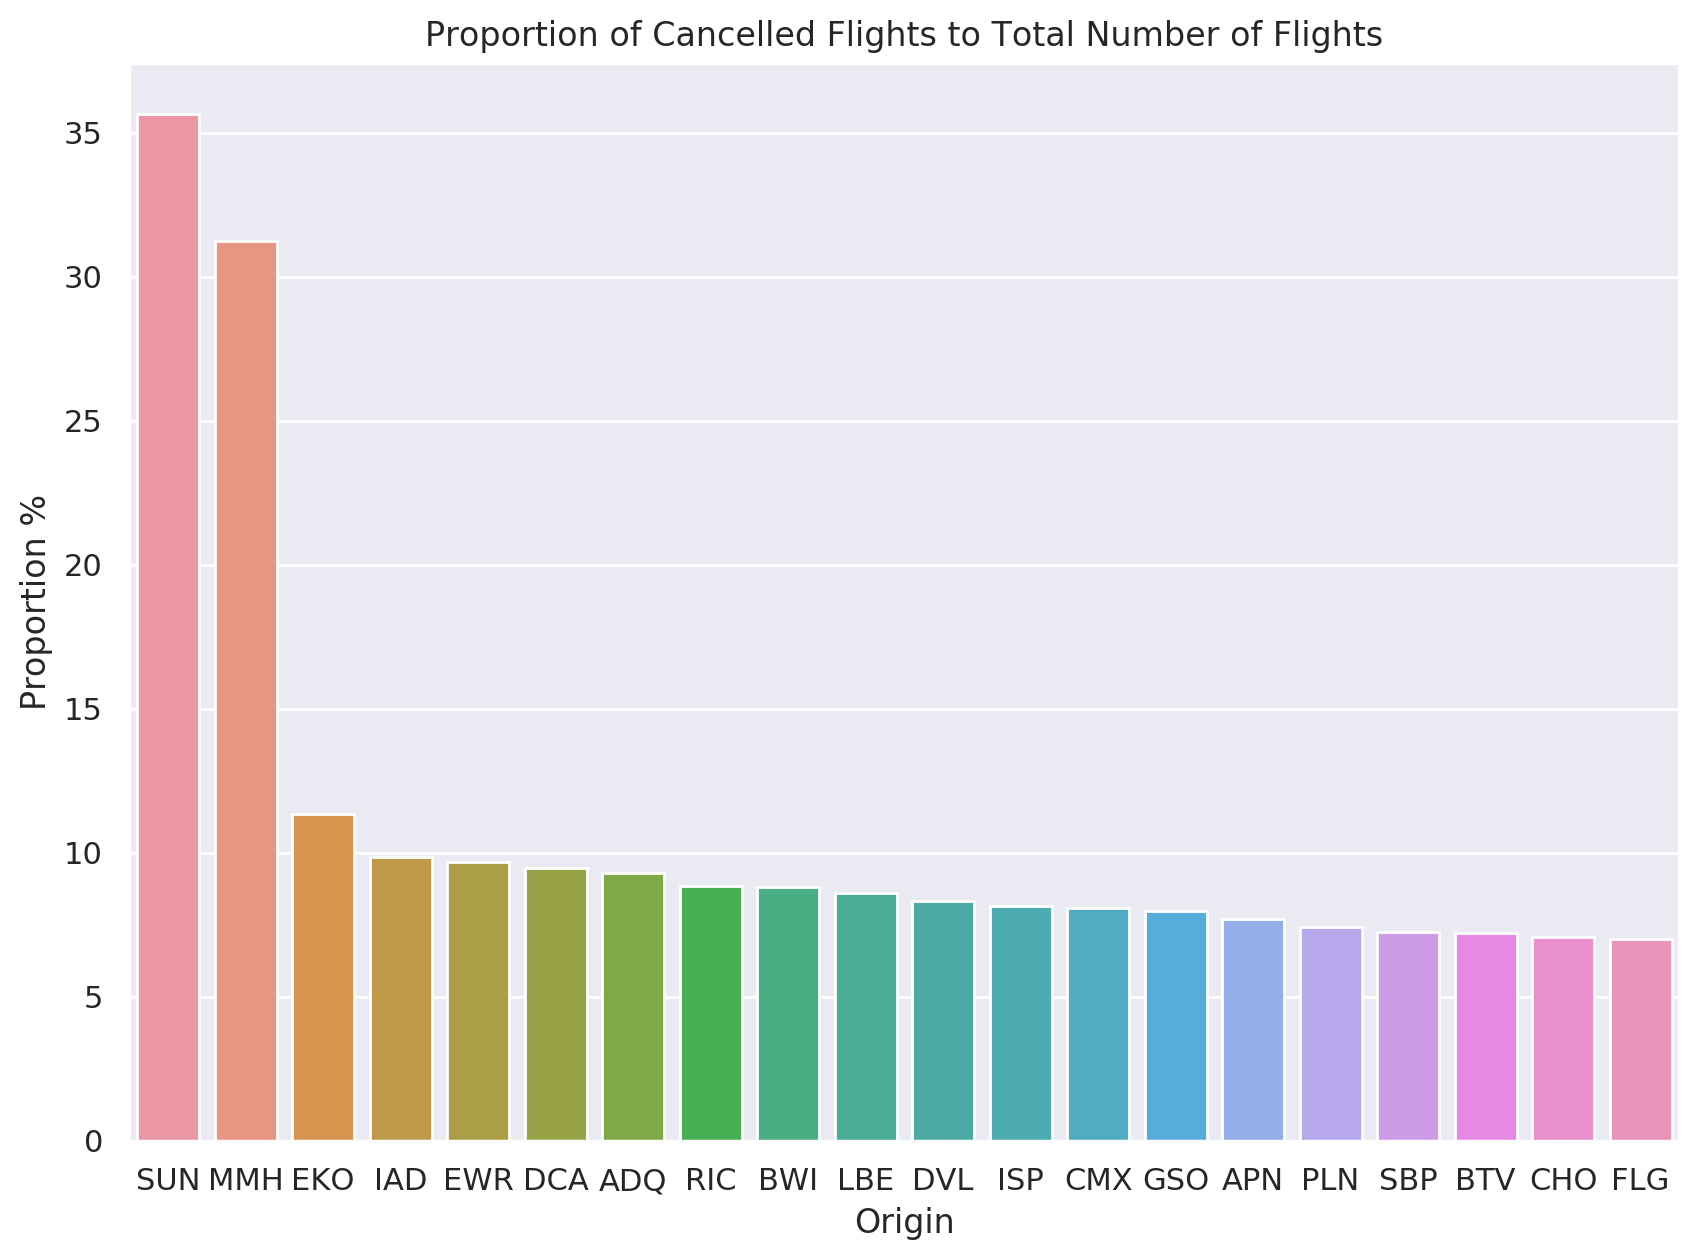

In [151]:
# Plot proportion of cancelled flights to total number of flights
g_bar=sns.barplot(x="Origin", y="Proportion %", data=df_prop.iloc[0:20])
g_bar.set_title("Proportion of Cancelled Flights to Total Number of Flights")

**Surprisingly, the Newark Liberty International Airport (EWR) that has the highest number of cancelled flights didn't have the highest proportion rate, which is very likely because it also had a high number of flights flying from that airport. The Friedman Memorial Airport (SUN) and Mammoth Lakes Airport (MMH) have the highest proportion rate of flight cancellations to flights. In 2016, 35.65% of flights were cancelled at the  Friedman Memorial Airport (SUN), and 31.25% of flights were cancelled at the Mammoth Lakes Airport (MMH).**

### Section 2 - Detecting Data-Quality Issues: 

**We also want to make sure we analyze data quality and catch any data issues early on to avoid any misleading reports or biased models. We will investigate into data quality and class imbalances.**

#### *Checking on Data Types and Missing Values:* 

In [173]:
# Summarize the flights dataset
def summarize(flights_df):
    
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    percentage_missing = []
    
    for item in flights_df.columns:
        variables.append(item)
        dtypes.append(flights_df[item].dtype)
        count.append(len(flights_df[item]))
        unique.append(len(flights_df[item].unique()))
        missing.append(flights_df[item].isna().sum())
        percentage_missing.append(round((flights_df[item].isna().sum() / len(flights_df[item])) * 100, 2))

    output = pd.DataFrame({
        'variable': variables, 
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing,
        'percentage_missing': percentage_missing
    })    
        
    return output

In [176]:
summarize(flights_df)

,variable,dtype,count,unique,missing,percentage_missing
0,Unnamed: 0,int64,445827,445827,0,0.0
1,Year,int64,445827,1,0,0.0
2,Quarter,int64,445827,1,0,0.0
3,Month,int64,445827,1,0,0.0
4,DayofMonth,int64,445827,31,0,0.0
...,...,...,...,...,...,...
79,Div2AirportID,float64,445827,6,445821,100.0
80,Div2AirportSeqID,float64,445827,6,445821,100.0
81,Div2WheelsOn,float64,445827,7,445821,100.0
82,Div2TotalGTime,float64,445827,5,445821,100.0


In [161]:
# Checking missing values on target variable - cancelled flights
flights_df['Cancelled'].isna().sum()

0

In [179]:
# Filtering columns that has more than 80% missing values
summarize(flights_df).loc[summarize(flights_df)['percentage_missing'] >= 80.0]

,variable,dtype,count,unique,missing,percentage_missing
49,CancellationCode,object,445827,4,434162,97.38
57,CarrierDelay,float64,445827,580,374945,84.10
58,WeatherDelay,float64,445827,315,374945,84.10
59,NASDelay,float64,445827,296,374945,84.10
60,SecurityDelay,float64,445827,58,374945,84.10
61,LateAircraftDelay,float64,445827,392,374945,84.10
62,FirstDepTime,float64,445827,977,443275,99.43
63,TotalAddGTime,float64,445827,150,443275,99.43
64,LongestAddGTime,float64,445827,148,443275,99.43
66,DivReachedDest,float64,445827,3,444963,99.81


**There are no missing values on our target variable - 'cancelled flights'. Also, it will be better to remove the columns with more than 80% missing values, which will be done in the pre-processing step.** 

#### *Checking on Class imbalance:* 

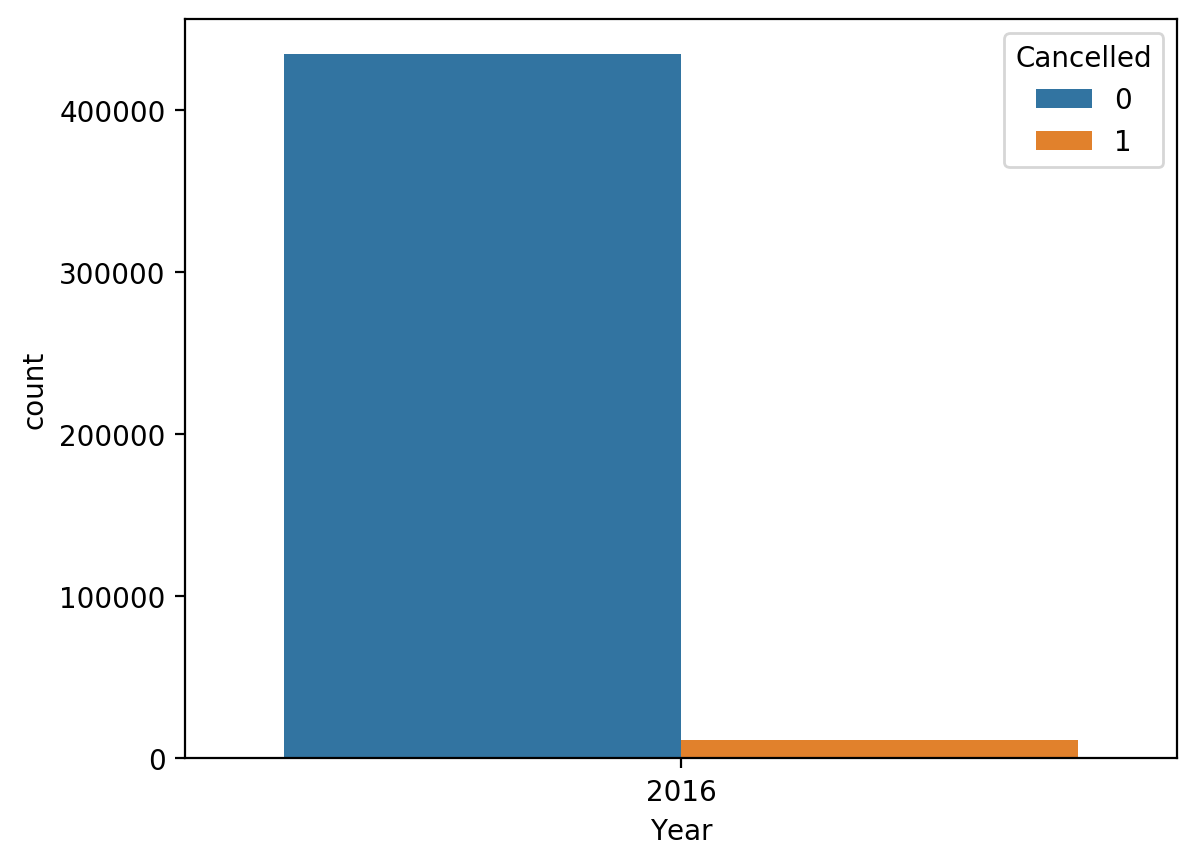

In [65]:
# Checking the class balance on our target variable 'Cancelled' as cancelled fllights
sns.countplot(data=flights_df, x="Year", hue="Cancelled")
plt.show()

**Class imbalance is where the number of instances of one class far exceeds the other. It happens when there are infrequent occurrences in one of the classes, it makes it hard to find sufficient samples. In this case, since we have a high number of cancelled flights, we considered this highly imbalanced. To avoid showing bias toward the majority class, further balancing technique is required to correct this issue, which will be done in the data-preprocessing stage.** 

## Data Preprocessing:

### *Data Cleaning/Preparation on Airline Flight data -*

In [82]:
# Removing the columns with more than 80% missing data in the flight data as investigated in EDA: 
columns=['CarrierDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'FirstDepTime',
         'TotalAddGTime', 'LongestAddGTime', 'DivReachedDest', 'DivActualElapsedTime', 'DivArrDelay',
         'DivDistance', 'Div1Airport', 'Div1AirportID', 'Div1AirportSeqID', 'Div1WheelsOn', 'Div1TotalGTime',
         'Div1LongestGTime', 'Div1WheelsOff', 'Div1TailNum', 'Div2Airport', 'Div2AirportID', 'Div2AirportSeqID',
         'Div2WheelsOn', 'Div2TotalGTime', 'Div2LongestGTime']

flights_df.drop(columns, inplace=True, axis=1)

In [83]:
flights_df.head()

,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,WeatherDelay,DivAirportLandings
0,0,2016,1,1,6,3,2016-01-06,AA,19805,AA,...,NaN,0,158.0,155.0,132.0,1.0,986.0,4,NaN,0
1,1,2016,1,1,7,4,2016-01-07,AA,19805,AA,...,NaN,0,158.0,150.0,126.0,1.0,986.0,4,NaN,0
2,2,2016,1,1,8,5,2016-01-08,AA,19805,AA,...,NaN,0,158.0,170.0,135.0,1.0,986.0,4,NaN,0
3,3,2016,1,1,9,6,2016-01-09,AA,19805,AA,...,NaN,0,158.0,151.0,129.0,1.0,986.0,4,NaN,0
4,4,2016,1,1,10,7,2016-01-10,AA,19805,AA,...,NaN,0,158.0,171.0,137.0,1.0,986.0,4,0.0,0


In [84]:
# Prepare flights data for datetime (timestamp) format by changing the type of CRSDepTime from int to string:
flights_df['CRSDepTime'] = flights_df['CRSDepTime'].astype('string')

#### For the JFK flights only:

In [85]:
# Subsetting the flight data for JFK airport
dff_Origin_JFK = flights_df[flights_df["Origin"]=="JFK"].reset_index()
dff_Origin_JFK.head()

,index,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,...,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,WeatherDelay,DivAirportLandings
0,88,88,2016,1,1,1,5,2016-01-01,AA,19805,...,NaN,0,385.0,366.0,324.0,1.0,2422.0,10,NaN,0
1,89,89,2016,1,1,2,6,2016-01-02,AA,19805,...,NaN,0,385.0,377.0,334.0,1.0,2422.0,10,0.0,0
2,90,90,2016,1,1,3,7,2016-01-03,AA,19805,...,NaN,0,385.0,410.0,337.0,1.0,2422.0,10,0.0,0
3,91,91,2016,1,1,4,1,2016-01-04,AA,19805,...,NaN,0,385.0,376.0,326.0,1.0,2422.0,10,0.0,0
4,92,92,2016,1,1,5,2,2016-01-05,AA,19805,...,NaN,0,382.0,358.0,327.0,1.0,2422.0,10,NaN,0


In [86]:
# Fill CRSDepTime with the right amount of zeros to the left and right depending on the original length of the field:

for x in range(0,len(dff_Origin_JFK)):
#for x in range(0,5):
    if len(dff_Origin_JFK.loc[x,'CRSDepTime']) == 4:
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].ljust(6,'0')
    if len(dff_Origin_JFK.loc[x,'CRSDepTime']) == 2:
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].ljust(4,'0')
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].rjust(6,'0')
    else:
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].ljust(5,'0')
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].rjust(6,'0')

In [87]:
for x in range(len(dff_Origin_JFK)):
    dff_Origin_JFK.loc[x,'CRSDepTime']=pd.to_datetime(dff_Origin_JFK.loc[x,'CRSDepTime'], format='%H%M%S').strftime('%H:%M:%S')

In [88]:
dff_Origin_JFK['FlightDate'] = dff_Origin_JFK['FlightDate'].astype(str) + ' ' + dff_Origin_JFK['CRSDepTime'].astype(str) 

In [89]:
dff_Origin_JFK.drop(['Unnamed: 0'],axis=1,inplace=True)

In [90]:
dff_Origin_JFK['FlightDate'] = pd.to_datetime(dff_Origin_JFK['FlightDate'], 
                                          format='%Y-%m-%d %H:%M:%S')

In [91]:
dff_Origin_JFK.head()

,index,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,WeatherDelay,DivAirportLandings
0,88,2016,1,1,1,5,2016-01-01 18:25:00,AA,19805,AA,...,NaN,0,385.0,366.0,324.0,1.0,2422.0,10,NaN,0
1,89,2016,1,1,2,6,2016-01-02 18:25:00,AA,19805,AA,...,NaN,0,385.0,377.0,334.0,1.0,2422.0,10,0.0,0
2,90,2016,1,1,3,7,2016-01-03 18:25:00,AA,19805,AA,...,NaN,0,385.0,410.0,337.0,1.0,2422.0,10,0.0,0
3,91,2016,1,1,4,1,2016-01-04 18:25:00,AA,19805,AA,...,NaN,0,385.0,376.0,326.0,1.0,2422.0,10,0.0,0
4,92,2016,1,1,5,2,2016-01-05 18:20:00,AA,19805,AA,...,NaN,0,382.0,358.0,327.0,1.0,2422.0,10,NaN,0


In [92]:
dff_Origin_JFK_mod=dff_Origin_JFK.copy()
dff_Origin_JFK_mod['FlightDate']=dff_Origin_JFK_mod['FlightDate'].dt.date

In [93]:
dff_Origin_JFK_mod.head()

,index,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,WeatherDelay,DivAirportLandings
0,88,2016,1,1,1,5,2016-01-01,AA,19805,AA,...,NaN,0,385.0,366.0,324.0,1.0,2422.0,10,NaN,0
1,89,2016,1,1,2,6,2016-01-02,AA,19805,AA,...,NaN,0,385.0,377.0,334.0,1.0,2422.0,10,0.0,0
2,90,2016,1,1,3,7,2016-01-03,AA,19805,AA,...,NaN,0,385.0,410.0,337.0,1.0,2422.0,10,0.0,0
3,91,2016,1,1,4,1,2016-01-04,AA,19805,AA,...,NaN,0,385.0,376.0,326.0,1.0,2422.0,10,0.0,0
4,92,2016,1,1,5,2,2016-01-05,AA,19805,AA,...,NaN,0,382.0,358.0,327.0,1.0,2422.0,10,NaN,0


#### For the entire flights dataframe - (Might not need)

In [77]:
# Fill CRSDepTime with the right amount of zeros to the left and right depending on the original length of the field:

#for x in range(0,len(flights_df)):
    #if len(flights_df.loc[x,'CRSDepTime']) == 4:
        #flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].ljust(6,'0')
    #if len(flights_df.loc[x,'CRSDepTime']) == 2:
        #flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].ljust(4,'0')
        #flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].rjust(6,'0')
    #else:
        #lights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].ljust(5,'0')
        #flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].rjust(6,'0')
        
#for x in range(len(flights_df)):
    #flights_df.loc[x,'CRSDepTime']=pd.to_datetime(flights_df.loc[x,'CRSDepTime'], format='%H%M%S').strftime('%H:%M:%S')

In [78]:
#flights_df['FlightDate'] = flights_df['FlightDate'].astype(str) + ' ' + flights_df['CRSDepTime'].astype(str) 

In [79]:
#flights_df.head()

### *Data Cleaning/Preparation on Weather data -*

In [94]:
# Remove prefix K on airport codes so we can match them to flight data:
weather_df['AirportCode'] = weather_df['AirportCode'].str[1:]

In [95]:
# Rename weather data 2016 start and end datetimes:
weather_df.rename(columns={'StartTime(UTC)':'StartTime'}, inplace=True)
weather_df.rename(columns={'EndTime(UTC)':'EndTime'}, inplace=True)

In [96]:
weather_df.rename(columns={'Precipitation(in)':'Precipitation'}, inplace=True)

In [97]:
weather_df.drop(["Unnamed: 0","EventId"], axis=1, inplace=True)

In [98]:
weather_df['StartTime'] = pd.to_datetime(weather_df['StartTime'], 
                                          format='%Y-%m-%d %H:%M:%S')
weather_df['EndTime'] = pd.to_datetime(weather_df['EndTime'], 
                                          format='%Y-%m-%d %H:%M:%S')

In [99]:
weather_df.head()

,Type,Severity,StartTime,EndTime,Precipitation,TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


#### For the JFK flights only:

In [39]:
# Subsetting the weather data for JFK airport
dff_Weather_JFK = weather_df[weather_df["AirportCode"]=="JFK"].reset_index()
dff_Weather_JFK.head()

,index,Type,Severity,StartTime,EndTime,Precipitation,TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,52242,Rain,Light,2016-01-10 03:51:00,2016-01-10 06:51:00,0.01,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0
1,52243,Rain,Light,2016-01-10 08:51:00,2016-01-10 09:51:00,0.05,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0
2,52244,Rain,Moderate,2016-01-10 09:51:00,2016-01-10 10:51:00,0.25,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0
3,52245,Rain,Heavy,2016-01-10 10:51:00,2016-01-10 11:33:00,0.31,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0
4,52246,Rain,Moderate,2016-01-10 11:33:00,2016-01-10 14:51:00,0.84,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0


In [40]:
# Subsetting the weather data for Jan
#weather_df['StartTime'] = pd.to_datetime(weather_df.StartTime, format='%Y-%m-%d %H:%M:%S')

#dff_Weather_Jan = weather_df[weather_df["StartTime"].dt.month == 1].reset_index()
#dff_Weather_Jan.head()

In [41]:
# Find all possible unique values for weather type and weather severity in the weather dataframe:
Type_unique=weather_df['Type'].unique()
Severity_unique=weather_df['Severity'].unique()

In [42]:
# Generate all possible combinations for weather
# type and severity so that we assign a code called weather_code
# This feature can be used by data science teams to see if there is a
# relationship with cancellations and the combination of such 
# weather conditions:
all_combinations = list(itertools.product(Type_unique, Severity_unique))
Weather_comb_var = pd.DataFrame(all_combinations, columns=['Type','Severity'])

In [43]:
# Add new feature to the subset weather_2016 JFK data
weather_code = []

for i in dff_Weather_JFK.index:
    for x in Weather_comb_var.index:
        if (dff_Weather_JFK.loc[i, 'Type'] == Weather_comb_var.loc[x,'Type']) & (dff_Weather_JFK.loc[i, 'Severity'] == Weather_comb_var.loc[x,'Severity']):
            weather_code.append(x)
 
dff_Weather_JFK['Weather_Comb_Var'] = weather_code

In [44]:
dff_Weather_JFK['StartTime'] = pd.to_datetime(dff_Weather_JFK['StartTime'], 
                                          format='%Y-%m-%d %H:%M:%S')
dff_Weather_JFK['EndTime'] = pd.to_datetime(dff_Weather_JFK['EndTime'], 
                                          format='%Y-%m-%d %H:%M:%S')

In [45]:
dff_Weather_JFK.head(30)

,index,Type,Severity,StartTime,EndTime,Precipitation,TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode,Weather_Comb_Var
0,52242,Rain,Light,2016-01-10 03:51:00,2016-01-10 06:51:00,0.01,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
1,52243,Rain,Light,2016-01-10 08:51:00,2016-01-10 09:51:00,0.05,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
2,52244,Rain,Moderate,2016-01-10 09:51:00,2016-01-10 10:51:00,0.25,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,26
3,52245,Rain,Heavy,2016-01-10 10:51:00,2016-01-10 11:33:00,0.31,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,27
4,52246,Rain,Moderate,2016-01-10 11:33:00,2016-01-10 14:51:00,0.84,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,26
5,52247,Fog,Severe,2016-01-10 16:51:00,2016-01-10 21:26:00,0.00,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,7
6,52248,Rain,Light,2016-01-10 21:26:00,2016-01-10 22:11:00,0.05,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
7,52249,Rain,Light,2016-01-10 22:51:00,2016-01-10 23:51:00,0.01,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
8,52250,Rain,Light,2016-01-12 21:51:00,2016-01-12 22:51:00,0.00,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
9,52251,Snow,Light,2016-01-14 10:51:00,2016-01-14 11:51:00,0.00,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,0


### *Data Cleaning/Preparation on JFK Weather data -*

In [100]:
# Clean up weather for JFK data where there is a T that stands for "trace":
JFK_weather_data['Precipitation']=JFK_weather_data['Precipitation'].replace(['T'], 0.0001)
JFK_weather_data['Snow_Depth']=JFK_weather_data['Snow_Depth'].replace(['T'], 0.0001)
JFK_weather_data['New_Snow']=JFK_weather_data['New_Snow'].replace(['T'], 0.0001)

In [101]:
# Drop the last rows that give summary statistics:
JFK_weather_data.drop(JFK_weather_data.tail(3).index,inplace=True)

In [102]:
# Convert the Date column into the proper YYYYMMDD format:
JFK_weather_data['Date'] = pd.to_datetime(JFK_weather_data['Date'], 
                                          format='%m/%d/%Y').dt.date

In [103]:
# Get January data on JFK weather
JFK_weather_data.head(31)

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,2016-01-01,44.0,36.0,40,5.4,25,0,0,0,0
1,2016-01-02,41.0,34.0,37.5,3.1,27,0,0,0,0
2,2016-01-03,48.0,35.0,41.5,7.3,23,0,0,0,0
3,2016-01-04,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,2016-01-05,29.0,12.0,20.5,-13.4,44,0,0,0,0
5,2016-01-06,40.0,21.0,30.5,-3.2,34,0,0,0,0
6,2016-01-07,46.0,27.0,36.5,3,28,0,0,0,0
7,2016-01-08,47.0,32.0,39.5,6.1,25,0,0,0,0
8,2016-01-09,53.0,40.0,46.5,13.3,18,0,0.02,0,0
9,2016-01-10,58.0,41.0,49.5,16.4,15,0,1.28,0,0


### *Data Cleaning/Preparation on Airport Code data -*

In [104]:
# Split up the "Description" field in the original aiport dataframe So that fields mean something more -
# the airport code is followed by the related airport name and it's city and state:
AirportCodes_df[['City_State', 'Airport']] = AirportCodes_df['Description'].str.split(':', expand=True)
AirportCodes_df= AirportCodes_df.drop('Description', axis=1)
AirportCodes_df[['City', 'State']] = AirportCodes_df['City_State'].str.split(',', n=1, expand=True)
AirportCodes_df= AirportCodes_df.drop('City_State', axis=1)

In [105]:
AirportCodes_df['City']=AirportCodes_df['City'].astype('string')
AirportCodes_df['Airport']=AirportCodes_df['Airport'].astype('string')
AirportCodes_df['State']=AirportCodes_df['State'].astype('string')
AirportCodes_df['Code']=AirportCodes_df['Code'].astype('string')

In [106]:
AirportCodes_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [107]:
AirportCodes_df.head()

,Code,Airport,City,State
0,01A,Afognak Lake Airport,Afognak Lake,AK
1,03A,Bear Creek Mining Strip,Granite Mountain,AK
2,04A,Lik Mining Camp,Lik,AK
3,05A,Little Squaw Airport,Little Squaw,AK
4,06A,Kizhuyak Bay,Kizhuyak,AK


### *Check Sizes of Final Dataframes for Combination -*

In [108]:
# Check JFK Weather datafrane
dff_Weather_JFK.shape

(443, 15)

In [109]:
# Check JFK Flights dataframe
dff_Origin_JFK.shape

(8027, 59)

In [110]:
# Check weather combination
Weather_comb_var.head()

,Type,Severity
0,Snow,Light
1,Snow,Severe
2,Snow,Moderate
3,Snow,Heavy
4,Snow,UNK


### *Combine Features of Interest -*

In [111]:
# Grap only the columns of interest from JFK flights data:
JFK_Flights_FS = dff_Origin_JFK.copy()
JFK_Flights_FS = JFK_Flights_FS[["FlightDate",
                                "DayOfWeek",
                                "AirlineID",
                                "Origin",
                                "Dest",
                                "WeatherDelay", 
                                "CancellationCode",
                                "Cancelled"]]

In [112]:
# Pre-assign weather type/severity conditions
# as fair before modifying based on the watherUS_2016 data
# if the combination variable is 99, the weather was fair and normal:
JFK_Flights_FS['Origin_Weather_Type'] = 'Fair'
JFK_Flights_FS['Origin_Weather_Severity'] = 'Normal'
JFK_Flights_FS['Origin_Weather_Comb'] = 99
JFK_Flights_FS['Origin_Weather_Precipitation'] = 0.0
JFK_Flights_FS['Dest_Weather_Type'] = 'Fair'
JFK_Flights_FS['Dest_Weather_Severity'] = 'Normal'
JFK_Flights_FS['Dest_Weather_Comb'] = 99
JFK_Flights_FS['Dest_Weather_Precipitation'] = 0.0

In [113]:
# If the flight is not canceled, the code is 'Z':
JFK_Flights_FS['CancellationCode'].replace(np.nan, value='Z', inplace = True)
JFK_Flights_FS['WeatherDelay'].replace(np.nan, value=0.0, inplace = True)

In [114]:
JFK_Flights_FS.head(500)

,FlightDate,DayOfWeek,AirlineID,Origin,Dest,WeatherDelay,CancellationCode,Cancelled,Origin_Weather_Type,Origin_Weather_Severity,Origin_Weather_Comb,Origin_Weather_Precipitation,Dest_Weather_Type,Dest_Weather_Severity,Dest_Weather_Comb,Dest_Weather_Precipitation
0,2016-01-01 18:25:00,5,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
1,2016-01-02 18:25:00,6,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
2,2016-01-03 18:25:00,7,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
3,2016-01-04 18:25:00,1,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
4,2016-01-05 18:20:00,2,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2016-01-17 10:30:00,7,19805,JFK,SFO,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
496,2016-01-18 10:30:00,1,19805,JFK,SFO,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
497,2016-01-19 10:30:00,2,19805,JFK,SFO,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
498,2016-01-20 10:30:00,3,19805,JFK,SFO,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0


### *Match Flight Dates with WeatherUS_2016 dates to Add Weather Features -*

In [115]:
for i in range(0,len(JFK_Flights_FS)):
    for x in range(0,len(dff_Weather_JFK)):
        if (JFK_Flights_FS.loc[i,'FlightDate'].date() == dff_Weather_JFK.loc[x,'StartTime'].date()) | (JFK_Flights_FS.loc[i,'FlightDate'].date() == dff_Weather_JFK.loc[x,'EndTime'].date()):
            #print("match")
            #print(i)
            JFK_Flights_FS.loc[i,'Origin_Weather_Type'] = dff_Weather_JFK.loc[x,'Type']
            JFK_Flights_FS.loc[i,'Origin_Weather_Severity'] = dff_Weather_JFK.loc[x,'Severity']
            JFK_Flights_FS.loc[i,'Origin_Weather_Comb'] = dff_Weather_JFK.loc[x,'Weather_Comb_Var']
            JFK_Flights_FS.loc[i,'Origin_Weather_Precipitation'] = dff_Weather_JFK.loc[x,'Precipitation']
            # exit out of the weather dataframe once a match is found:
            x=len(dff_Weather_JFK)+1

In [116]:
JFK_Flights_FS.drop(['Dest_Weather_Comb','Dest_Weather_Type',
                    'Dest_Weather_Severity',
                    'Dest_Weather_Precipitation'],axis=1,inplace=True)

In [117]:
# Saving the matching JFK flights and weather to S3 bucket
JFK_Flights_FS.to_csv('s3://sagemaker-us-east-1-328876407652/airline_data/JFK_Flight_Weather_Prelim.csv')

### *Match FlightDates and Detailed JFK weather data -*

In [118]:
JFK_weather_data.head()

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,2016-01-01,44.0,36.0,40,5.4,25,0,0,0,0
1,2016-01-02,41.0,34.0,37.5,3.1,27,0,0,0,0
2,2016-01-03,48.0,35.0,41.5,7.3,23,0,0,0,0
3,2016-01-04,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,2016-01-05,29.0,12.0,20.5,-13.4,44,0,0,0,0


In [119]:
JFK_Flights_FS['Origin_MaxTemp'] = 0.0
JFK_Flights_FS['Origin_MinTemp'] = 0
JFK_Flights_FS['Origin_AvgTemp'] = 0
JFK_Flights_FS['Origin_DepTemp'] = 0.0
JFK_Flights_FS['Origin_HDD'] = 0.0
JFK_Flights_FS['Origin_CDD'] = 0.0
JFK_Flights_FS['Origin_New_Snow'] = 0.0
JFK_Flights_FS['Origin_Snow_Depth'] = 0.0

In [120]:
for i in range(0,len(JFK_Flights_FS)):
    for x in range(0,len(JFK_weather_data)):
        if (JFK_Flights_FS.loc[i,'FlightDate'].date() == JFK_weather_data.loc[x,'Date']):
            #print("match")
            #print(i)
            JFK_Flights_FS.loc[i,'Origin_MaxTemp'] = JFK_weather_data.loc[x,'MaxTemp']
            JFK_Flights_FS.loc[i,'Origin_MinTemp'] = JFK_weather_data.loc[x,'MinTemp']
            JFK_Flights_FS.loc[i,'Origin_AvgTemp'] = JFK_weather_data.loc[x,'AvgTemp']
            JFK_Flights_FS.loc[i,'Origin_DepTemp'] = JFK_weather_data.loc[x,'DepTemp']
            JFK_Flights_FS.loc[i,'Origin_HDD'] = JFK_weather_data.loc[x,'HDD']
            JFK_Flights_FS.loc[i,'Origin_CDD'] = JFK_weather_data.loc[x,'CDD']
            JFK_Flights_FS.loc[i,'Origin_New_Snow'] = JFK_weather_data.loc[x,'New_Snow']
            JFK_Flights_FS.loc[i,'Origin_Snow_Depth'] = JFK_weather_data.loc[x,'Snow_Depth']
                  
            # exit out of the weather dataframe once a match is found:
            x=len(JFK_weather_data)+1

In [121]:
JFK_Flights_FS.head(700)

,FlightDate,DayOfWeek,AirlineID,Origin,Dest,WeatherDelay,CancellationCode,Cancelled,Origin_Weather_Type,Origin_Weather_Severity,Origin_Weather_Comb,Origin_Weather_Precipitation,Origin_MaxTemp,Origin_MinTemp,Origin_AvgTemp,Origin_DepTemp,Origin_HDD,Origin_CDD,Origin_New_Snow,Origin_Snow_Depth
0,2016-01-01 18:25:00,5,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,44.0,36,40,5.4,25,0,0,0
1,2016-01-02 18:25:00,6,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,41.0,34,37.5,3.1,27,0,0,0
2,2016-01-03 18:25:00,7,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,48.0,35,41.5,7.3,23,0,0,0
3,2016-01-04 18:25:00,1,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,38.0,15,26.5,-7.5,38,0,0,0
4,2016-01-05 18:20:00,2,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,29.0,12,20.5,-13.4,44,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2016-01-21 17:30:00,4,19805,JFK,SAN,0.0,Z,0,Fair,Normal,99,0.00,39.0,27,33,0.8,32,0,0,0
696,2016-01-22 17:30:00,5,19805,JFK,SAN,0.0,Z,0,Fair,Normal,99,0.00,30.0,21,25.5,-6.7,39,0,0.2,0
697,2016-01-23 17:30:00,6,19805,JFK,SAN,0.0,B,1,Snow,Light,0,0.06,31.0,26,28.5,-3.7,36,0,30.3,7
698,2016-01-24 17:29:00,7,19805,JFK,SAN,0.0,B,1,Snow,Light,0,0.00,35.0,19,27,-5.2,38,0,0.1,28


In [122]:
JFK_Flights_Weather=JFK_Flights_FS.copy()

# Removing cancellation code, Weather Severity and Weather Type
JFK_Flights_Weather_F2=JFK_Flights_Weather.drop(['CancellationCode','Origin_Weather_Type','Origin_Weather_Severity'], axis=1)

In [125]:
JFK_Flights_Weather_F2.head()

,FlightDate,DayOfWeek,AirlineID,Origin,Dest,WeatherDelay,Cancelled,Origin_Weather_Comb,Origin_Weather_Precipitation,Origin_MaxTemp,Origin_MinTemp,Origin_AvgTemp,Origin_DepTemp,Origin_HDD,Origin_CDD,Origin_New_Snow,Origin_Snow_Depth
0,2016-01-01 18:25:00,5,19805,JFK,SEA,0.0,0,99,0.0,44.0,36,40,5.4,25,0,0,0
1,2016-01-02 18:25:00,6,19805,JFK,SEA,0.0,0,99,0.0,41.0,34,37.5,3.1,27,0,0,0
2,2016-01-03 18:25:00,7,19805,JFK,SEA,0.0,0,99,0.0,48.0,35,41.5,7.3,23,0,0,0
3,2016-01-04 18:25:00,1,19805,JFK,SEA,0.0,0,99,0.0,38.0,15,26.5,-7.5,38,0,0,0
4,2016-01-05 18:20:00,2,19805,JFK,SEA,0.0,0,99,0.0,29.0,12,20.5,-13.4,44,0,0,0


### *Saving matched up datasets to S3 bucket -*

In [126]:
# Saving the matching JFK flights and JFK weather
JFK_Flights_FS.to_csv('s3://sagemaker-us-east-1-328876407652/airline_data/JFK_Flight_Weather_Data_FinalSet.csv')

# Saving the subset JFK flights
dff_Origin_JFK.to_csv('s3://sagemaker-us-east-1-328876407652/airline_data/Flights_JFK/Flights_JFK_clean.csv')

# Saving the subset JFK weather
dff_Weather_JFK.to_csv('s3://sagemaker-us-east-1-328876407652/airline_data/Weather_JFK/Weather_JFK_clean.csv')

# Saving the JFK weather
JFK_weather_data.to_csv('s3://sagemaker-us-east-1-328876407652/airline_data/JFK_weather_detailed/Weather_JFK__detailed_clean.csv')

# Saving the modified subset JFK flights
dff_Origin_JFK_mod.to_csv('s3://sagemaker-us-east-1-328876407652/airline_data/Flights_JFK_mod/dff_Origin_JFK_mod.csv')

# Saving the final matching set for training & testing
JFK_Flights_Weather_F2.to_csv('s3://sagemaker-us-east-1-328876407652/airline_data/JFK_Flights_Weather_F2.csv')

In [68]:
table_JFK_flights = 'Flights_JFK'
table_JFK_weather2016 = 'Weather2016_JFK6'
table_JFK_weather_detailed = 'Weather_detailed_JFK6'
table_JFK_flights_mod = 'Flights_JFK_mod'

In [69]:
JFK_flight_path = 's3://sagemaker-us-east-1-328876407652/airline_data/Flights_JFK'
JFK_flight_path_mod = 's3://sagemaker-us-east-1-328876407652/airline_data/Flights_JFK_mod'
JFK_weather_path = 's3://sagemaker-us-east-1-328876407652/airline_data/Weather_JFK'
JFK_weather_detailed_path = 's3://sagemaker-us-east-1-328876407652/airline_data/JFK_weather_detailed'

### *Splitting the Combined Dataset into 90% Training, 5% Validation and 5% Test -*

In [127]:
# Split all data into 90% train and 10% holdout
df_train, df_holdout = train_test_split(JFK_Flights_Weather_F2, test_size=0.10, stratify=JFK_Flights_FS['Cancelled'])

In [128]:
# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout['Cancelled'])

### *Correcting Class Imabalance -* 

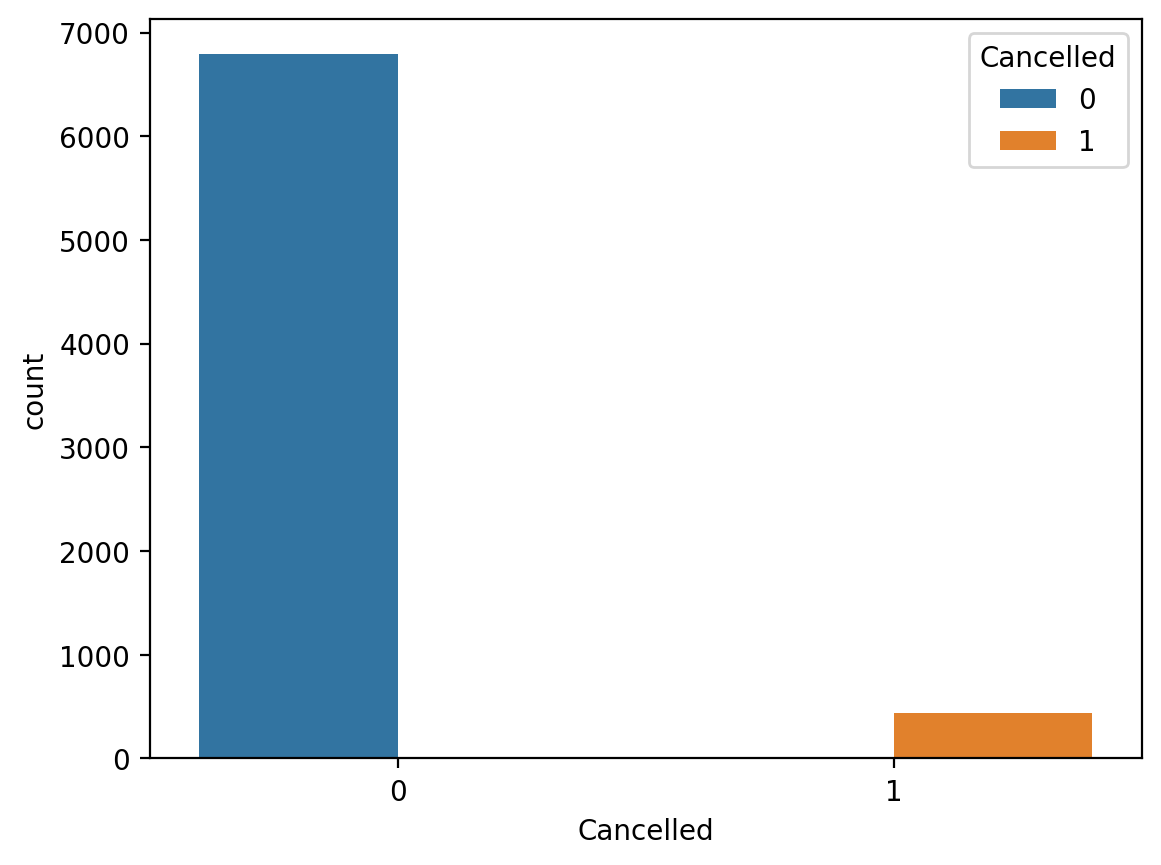

In [131]:
# Checking the distriubtion of 'Cancelled' in the training dataset
sns.countplot(data=df_train, x="Cancelled", hue="Cancelled")
plt.show()

In [142]:
df_train['Cancelled'].value_counts()

0    6790
1     434
Name: Cancelled, dtype: int64

**Since we have a serious class imbalance problem, we will combine both oversampling and undersampling method to create new data for the underrepresented class (1: 'Cancelled'). The goal is to increase the representation of the minority class 'Cancelled' to 30% since doing a 50-50 balance may lead to too much data being lost.**

In [145]:
X=df_train.drop(['Cancelled'],axis=1)
y=df_train[['Cancelled']] 

In [146]:
# Define resampling for combination of random oversampling and undersampling
oversample = RandomOverSampler(sampling_strategy=0.1)
undersample = RandomUnderSampler(sampling_strategy=0.5)

In [147]:
# Perform oversampling on Cancelled
X_over, y_over = oversample.fit_resample(X, y)

# Perform undersampling on Cancelled
X_under, y_under = undersample.fit_resample(X_over, y_over)

In [148]:
y_under['Cancelled'].value_counts()

0    1358
1     679
Name: Cancelled, dtype: int64

In [149]:
# Merging the features back on one dataset
df_train_balanced = pd.concat([X_under, y_under], axis=1)
df_train_balanced.head()

,FlightDate,DayOfWeek,AirlineID,Origin,Dest,WeatherDelay,Origin_Weather_Comb,Origin_Weather_Precipitation,Origin_MaxTemp,Origin_MinTemp,Origin_AvgTemp,Origin_DepTemp,Origin_HDD,Origin_CDD,Origin_New_Snow,Origin_Snow_Depth,Cancelled
0,2016-01-18 20:39:00,1,20409,JFK,PDX,0.0,0,0.0,33.0,20,26.5,-5.8,38,0,0.1,1,0
1,2016-01-20 17:30:00,3,20409,JFK,CLT,0.0,99,0.0,40.0,28,34,1.8,31,0,0,0,0
2,2016-01-21 19:40:00,4,20409,JFK,FLL,0.0,99,0.0,39.0,27,33,0.8,32,0,0,0,0
3,2016-01-25 08:05:00,1,19790,JFK,CHS,0.0,99,0.0,39.0,20,29.5,-2.7,35,0,0,26,0
4,2016-01-21 11:14:00,4,20409,JFK,BOS,0.0,99,0.0,39.0,27,33,0.8,32,0,0,0,0


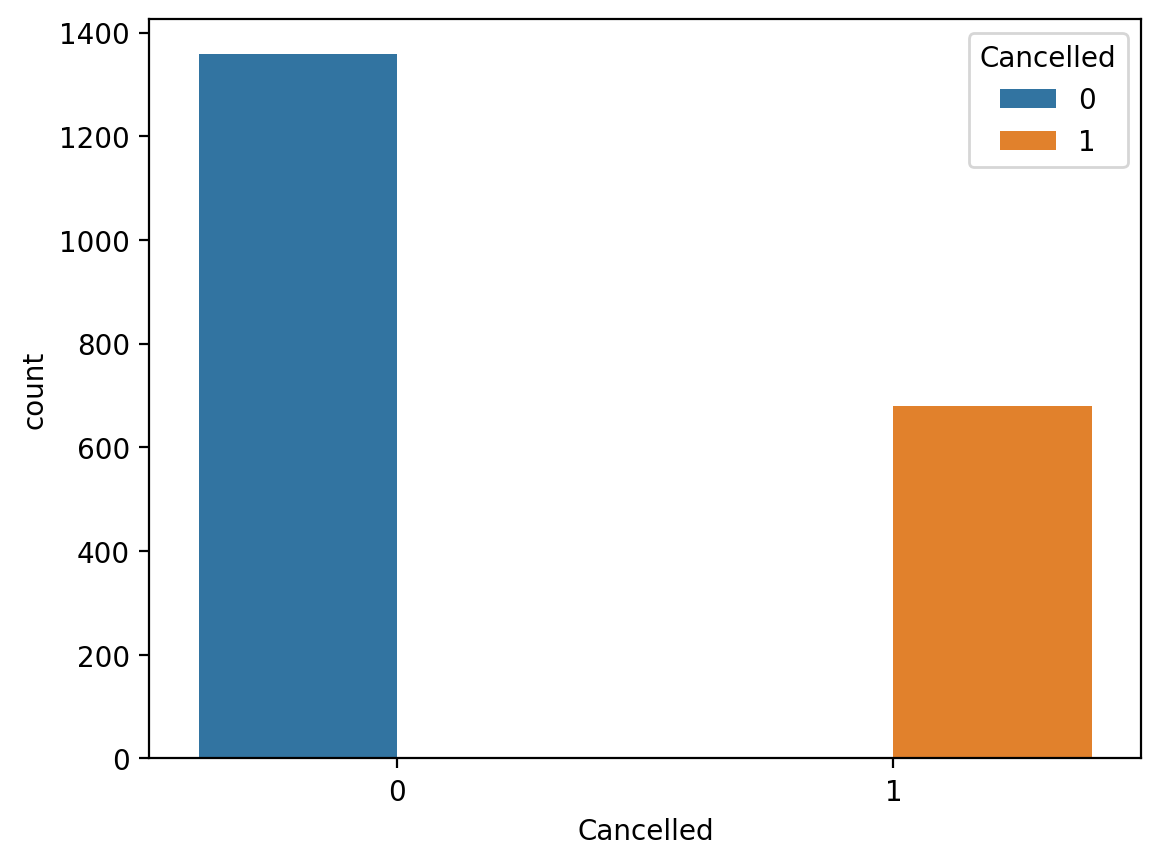

In [150]:
# Checking new class distribution after the correction process
sns.countplot(data=df_train_balanced, x="Cancelled", hue="Cancelled")
plt.show()

**The size of the minority class 'Cancelled' is now around 30% of the target variable.**

### *Correcting Class Imabalance - (Old version)*

In [74]:
# Calculate extra copies of minority class that needs to be balance the data
minority = df_train['Cancelled'] == 1
num_to_oversample = len(df_train) - 10*minority.sum()

In [86]:
df_positive_oversample = df_train[minority].sample(n=num_to_oversample, replace=True, random_state=888)

# Concatting the original training set with extra copies of minority class
df_train = pd.concat([df_train, df_positive_oversample])

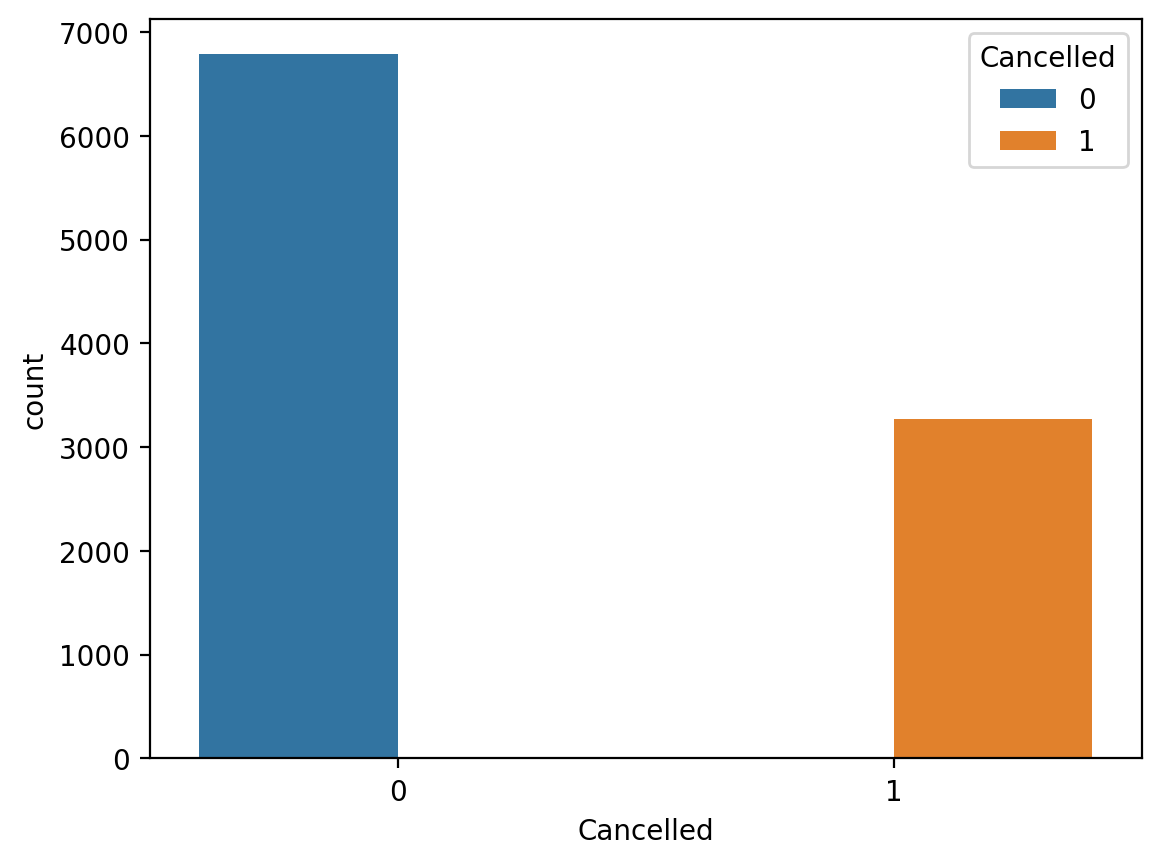

In [87]:
# Checking new class distribution after the correction process
sns.countplot(data=df_train, x="Cancelled", hue="Cancelled")
plt.show()

In [88]:
df_train['Cancelled'].value_counts()

0    6785
1    3273
Name: Cancelled, dtype: int64

### *Correcting Class Imabalance - (Old version)* 

In [66]:
# Correcting class imbalance in 'Cancelled' as cancelled flights
df_grouped_by = flights_df.groupby(["Year","Cancelled"])["Year","Cancelled"]
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))
df_balanced.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


(23330, 2)

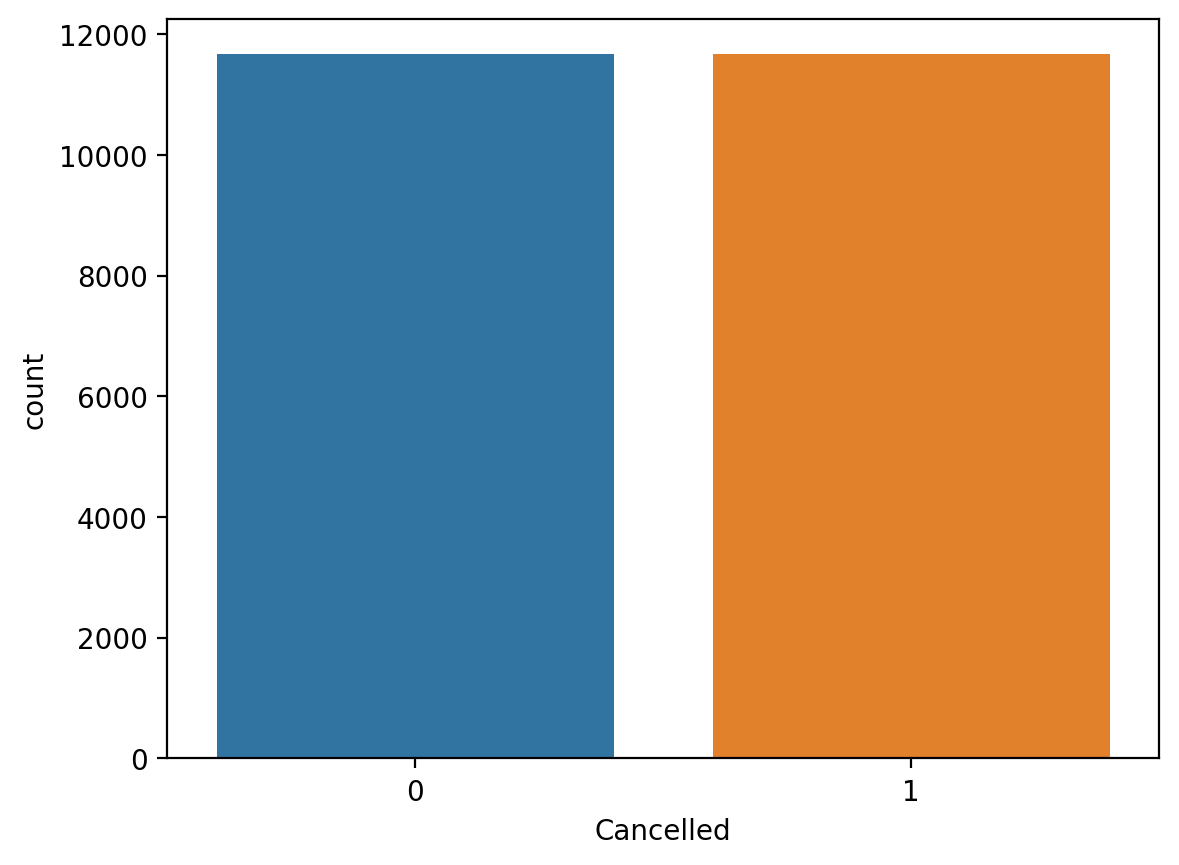

In [67]:
# Plot the new class balance
sns.countplot(data=df_balanced, x="Cancelled")